## Import libraries

In [1]:
# system and performance
import gc
import time
import os
import pickle


# date management
import datetime
import calendar


# data management
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

from itertools import product

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# machine learning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def create_directory(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print('directory '+path+' created succesfully !')
    else:
        print('directory '+path+' already exists')

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [4]:
# path to data
RAW_DATA_FOLDER = '../data/raw/'
DATA_FOLDER = '../data/'

##### Define core variable space and macro to reset variable space

In [5]:
loaded=%who_ls
loaded.append('loaded')

In [6]:
all_vars=%who_ls
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var

In [7]:
%macro reset_variable_space 6
loaded.append('reset_variable_space')

Macro `reset_variable_space` created. To execute, type its name (without quotes).
=== Macro contents: ===
all_vars=get_ipython().run_line_magic('who_ls', '')
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var
 

## -------------------------------------------------------------

# 0 - DATA CLEANING

- Cleaning of input dataframes
- Preliminary data analysis

## Import raw data

In [8]:
train_df        = pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'shops.csv'))

test_df         = pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'test.csv'))

In [9]:
print('items :' + str(items.shape))
print()
items.info(null_counts=True)
print('_'*40)
print()
print('item_categories :' + str(item_categories.shape))
print()
item_categories.info(null_counts=True)
print('_'*40)
print()
print('shops :' + str(shops.shape))
print()
shops.info(null_counts=True)

items :(22170, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
________________________________________

item_categories :(84, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
________________________________________

shops :(60, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_name    60 non-null object
shop_id      60 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [10]:
print('train_df :' + str(train_df.shape))
print()
train_df.info(null_counts=True)
print('_'*40)
print()
print('test set :' + str(test_df.shape))
print()
test_df.info(null_counts=True)
print('_'*40)
print('_'*40)
print()
print('number of different items in training set : '+str(train_df['item_id'].nunique()) + ' / ' + str(items.item_id.nunique()))
print('number of different items in test set : '+str(test_df['item_id'].nunique()) + ' / ' + str(items.item_id.nunique()))
print('number of different items ONLY in test set : '+str(test_df.loc[~test_df['item_id'].isin(train_df['item_id']),'item_id'].nunique()))
print()
print('number of different shops in training set : '+str(train_df['shop_id'].nunique()) + ' / ' + str(shops.shop_id.nunique()) )
print('number of different shops in test set : '+str(test_df['shop_id'].nunique()) + ' / ' + str(shops.shop_id.nunique()))

train_df :(2935849, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              2935849 non-null object
date_block_num    2935849 non-null int64
shop_id           2935849 non-null int64
item_id           2935849 non-null int64
item_price        2935849 non-null float64
item_cnt_day      2935849 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
________________________________________

test set :(214200, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB
________________________________________
________________________________________

number of different items in training set : 21807 / 22170
number of different items in test set : 5100 / 22170
number of different items ONLY in test set 

## BASIC PREPROCESSING

In [11]:
# rename features
train_df.rename({'date_block_num':'month_id', 'item_cnt_day':'item_quantity'},axis=1,inplace=True)

In [12]:
# convert date feature to datetime type
train_df['date']=pd.DataFrame(pd.to_datetime(train_df['date'],format="%d.%m.%Y"))

In [13]:
train_df['day_id']=(train_df['date']-train_df['date'].min()).dt.days

In [14]:
# discard returned articles (items with quantity < 1)
# we are only interested in predicting the sales, returned articles are irrelevant to the study
print('percentage of realisations that represent returned articles : ' +str(round((train_df['item_quantity']<0).sum()/(train_df['item_quantity']>=0).sum()*100,2)) + ' %')
train_df.drop(train_df[train_df['item_quantity']<0].index,axis=0,inplace=True)

percentage of realisations that represent returned articles : 0.25 %


## PREPROCESSING OF THE SHOPS

### Analysis of duplicate shops

In [15]:
print('shop  0 : ' + shops.shop_name[0])
print('shop 57 : ' + shops.shop_name[57])
print()

tmp=train_df[(train_df['shop_id']==0) | (train_df['shop_id']==57)].drop('month_id',axis=1)

print('## Value counts ##')
print(tmp['shop_id'].value_counts())
print()

print('## Activity period ##')
print('shop  0 : ' + tmp[tmp.shop_id==0].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==0].date.max().strftime("%d.%m.%Y"))
print('shop 57 : ' + tmp[tmp.shop_id==57].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==57].date.max().strftime("%d.%m.%Y"))
print()

print('## The period of activities do not overlap and are consecutive !! ##')
print('## SHOP 0 = SHOP 57 ##')

del tmp

shop  0 : !Якутск Орджоникидзе, 56 фран
shop 57 : Якутск Орджоникидзе, 56

## Value counts ##
57    117114
0       9857
Name: shop_id, dtype: int64

## Activity period ##
shop  0 : 03.01.2013 --- 28.02.2013
shop 57 : 01.03.2013 --- 31.10.2015

## The period of activities do not overlap and are consecutive !! ##
## SHOP 0 = SHOP 57 ##


In [16]:
print('shop  1 : ' + shops.shop_name[1])
print('shop 58 : ' + shops.shop_name[58])
print()

tmp=train_df[(train_df['shop_id']==1) | (train_df['shop_id']==58)].drop('month_id',axis=1)

print('## Value counts ##')
print(tmp['shop_id'].value_counts())
print()

print('## Activity period ##')
print('shop  1 : ' + tmp[tmp.shop_id==1].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==1].date.max().strftime("%d.%m.%Y"))
print('shop 58 : ' + tmp[tmp.shop_id==58].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==58].date.max().strftime("%d.%m.%Y"))
print()

print('## The period of activities do not overlap and are consecutive !! ##')
print('## SHOP 1 = SHOP 58 ##')

del tmp

shop  1 : !Якутск ТЦ "Центральный" фран
shop 58 : Якутск ТЦ "Центральный"

## Value counts ##
58    71268
1      5678
Name: shop_id, dtype: int64

## Activity period ##
shop  1 : 03.01.2013 --- 28.02.2013
shop 58 : 01.03.2013 --- 31.10.2015

## The period of activities do not overlap and are consecutive !! ##
## SHOP 1 = SHOP 58 ##


In [17]:
print('shop 10 : ' + shops.shop_name[10])
print('shop 11 : ' + shops.shop_name[11])
print()

tmp=train_df[(train_df['shop_id']==10) | (train_df['shop_id']==11)].drop('month_id',axis=1)

print('## Value counts ##')
print(tmp['shop_id'].value_counts())
print()

print('## Activity period ##')
print('shop 10 : ' + tmp[tmp.shop_id==10].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==10].date.max().strftime("%d.%m.%Y"))
print('shop 11 : ' + tmp[tmp.shop_id==11].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==11].date.max().strftime("%d.%m.%Y"))
print()

print('### Count values per shop between 01.02.2015 --- 28.02.2015 ###')
print(tmp[(tmp['date'] <= tmp[tmp.shop_id==11].date.max()) & (tmp['date'] >= tmp[tmp.shop_id==11].date.min())]['shop_id'].value_counts())
print()

print('## The period of activities do not overlap !! ##')
print('## SHOP 10 = SHOP 11 ##')

del tmp

shop 10 : Жуковский ул. Чкалова 39м?
shop 11 : Жуковский ул. Чкалова 39м²

## Value counts ##
10    21397
11      499
Name: shop_id, dtype: int64

## Activity period ##
shop 10 : 02.01.2013 --- 31.10.2015
shop 11 : 01.02.2015 --- 28.02.2015

### Count values per shop between 01.02.2015 --- 28.02.2015 ###
11    499
Name: shop_id, dtype: int64

## The period of activities do not overlap !! ##
## SHOP 10 = SHOP 11 ##


In [18]:
print('shop 39 : ' + shops.shop_name[39])
print('shop 40 : ' + shops.shop_name[40])
print()

tmp=train_df[(train_df['shop_id']==39) | (train_df['shop_id']==40)].drop('month_id',axis=1)

print('## Value count ##')
print(tmp['shop_id'].value_counts())
print()

print('## Each shop individually has no duplicate sale...')
tmpa=train_df[(train_df['shop_id']==39)].drop('month_id',axis=1)
tmpb=train_df[(train_df['shop_id']==40)].drop('month_id',axis=1)
print('duplicates date/item (shop 39)      : ' + str(tmpa.duplicated(subset=['date','item_id'],keep=False).sum()))
print('duplicates date/item (shop 40)      : ' + str(tmpb.duplicated(subset=['date','item_id'],keep=False).sum()))
print('...but the reunion of both has many...')
print('duplicates date/item                : ' + str(tmp.duplicated(subset=['date','item_id'],keep=False).sum()))
print('duplicates date/item/price          : ' + str(tmp.duplicated(subset=['date','item_id','item_price'],keep=False).sum()))
print('duplicates date/item/price/quantity : ' + str(tmp.duplicated(subset=['date','item_id','item_price','item_quantity'],keep=False).sum()))
print('...so all duplicates are exactly paired between the two shops (39,40)! ##')
print()

print('## The period of activities overlap ##')
print('shop 39 : ' + tmp[tmp.shop_id==39].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==39].date.max().strftime("%d.%m.%Y"))
print('shop 40 : ' + tmp[tmp.shop_id==40].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp[tmp.shop_id==40].date.max().strftime("%d.%m.%Y"))
print()

print('####################################')
print('## Restrict dataframe to overlapping period ##')
tmpr=tmp[tmp['date']<tmpb['date'].max()]
print(tmpr['shop_id'].value_counts())
print()

print('####################################')
pa=np.zeros(22170)
pa[tmpa['item_id'].unique()]=1
pa.astype(int)
pb=np.zeros(22170)
pb[tmpb['item_id'].unique()]=1
pb.astype(int)

print('number of different items sold in shop 39 : ' + str(sum(pa).astype(int)))
print('number of different items sold in shop 40 : ' + str(sum(pb).astype(int)))
print('number of different items sold in both shops : ' + str(sum(pa*pb).astype(int)))
print()

print("## It is likely that the shop 40 is an 'island' in the commercial center, related to the main shop 39 ##")
print("## The island 40 appears to have closed at the end of January 2015 ##")
print()

del tmp,tmpa,tmpb,tmpr,pa,pb

shop 39 : РостовНаДону ТРК "Мегацентр Горизонт"
shop 40 : РостовНаДону ТРК "Мегацентр Горизонт" Островной

## Value count ##
39    13403
40     4244
Name: shop_id, dtype: int64

## Each shop individually has no duplicate sale...
duplicates date/item (shop 39)      : 0
duplicates date/item (shop 40)      : 0
...but the reunion of both has many...
duplicates date/item                : 880
duplicates date/item/price          : 834
duplicates date/item/price/quantity : 360
...so all duplicates are exactly paired between the two shops (39,40)! ##

## The period of activities overlap ##
shop 39 : 01.03.2014 --- 31.10.2015
shop 40 : 01.03.2014 --- 29.01.2015

####################################
## Restrict dataframe to overlapping period ##
39    7542
40    4242
Name: shop_id, dtype: int64

####################################
number of different items sold in shop 39 : 4096
number of different items sold in shop 40 : 817
number of different items sold in both shops : 683

## It is likely th

### Remove duplicate shops

In [19]:
# shops 0-57, 1-58, 10-11 are in fact the same but on different time periods: relabel similar shops with same id
# shops 0,1,11 are not present in the test set, but shops 57,58,10 are present so we keep the latter ids instead of the former

# shop 40 is likely to be an antenna of shop 39, so we aggregate their sales together (here we simply relabel shop 40 as shop 39, and we will aggregate the sales when grouping sales by (date,shop,item,price) in the next step)
# shop 40 is not present in the test set, but shop 39 is present so we keep the latter instead of the former

shops.drop(0,axis=0,inplace=True)
shops.drop(1,axis=0,inplace=True)
shops.drop(11,axis=0,inplace=True)
shops.drop(40,axis=0,inplace=True)

train_df.loc[train_df['shop_id']==0,'shop_id']=57
train_df.loc[train_df['shop_id']==1,'shop_id']=58
train_df.loc[train_df['shop_id']==11,'shop_id']=10
train_df.loc[train_df['shop_id']==40,'shop_id']=39

In [20]:
# group together sales by (date,shop_id,item_id,item_price)
train_df=train_df.groupby(list(train_df.columns.drop('item_quantity')),as_index=False).sum()
train_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928070 entries, 0 to 2928069
Data columns (total 7 columns):
date             2928070 non-null datetime64[ns]
month_id         2928070 non-null int64
shop_id          2928070 non-null int64
item_id          2928070 non-null int64
item_price       2928070 non-null float64
day_id           2928070 non-null int64
item_quantity    2928070 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 178.7 MB


In [21]:
print('Remaining duplicates in the training set : ' + str(train_df.duplicated(subset=['date','shop_id','item_id','item_price'],keep=False).sum()))

Remaining duplicates in the training set : 0


### Feature engineering: cities

In [22]:
# create feature city from shop name
shops['city'] = shops['shop_name'].str.extract('(\S+)\s', expand=False)
print('number of cities in the dataset : ' + str(shops.city.nunique()))
print('number of null cities : ' + str(shops.city.isnull().sum()))
shops.city.unique()

number of cities in the dataset : 31
number of null cities : 0


array(['Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж', 'Выездная',
       'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга', 'Коломна',
       'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [23]:
# label encoding of city names
shops['city_id']=pd.factorize(shops['city'])[0]

### Analysis of opening periods

In [24]:
tmp=train_df[['month_id','shop_id']].groupby('shop_id').agg({'month_id':['min','max','nunique']})
tmp[('month_id','laps')]=tmp[('month_id','max')]-tmp[('month_id','min')]+1
tmp=tmp.join(shops[['shop_id','shop_name','city','city_id']].set_index('shop_id'))
tmp.sort_values(by='city_id',inplace=True)
tmp

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(month_id, min)","(month_id, max)","(month_id, nunique)","(month_id, laps)",shop_name,city,city_id
shop_id,,,,,,,
2,0,33,34,34,"Адыгея ТЦ ""Мега""",Адыгея,0
3,0,33,34,34,"Балашиха ТРК ""Октябрь-Киномир""",Балашиха,1
4,0,33,34,34,"Волжский ТЦ ""Волга Молл""",Волжский,2
5,1,33,33,33,"Вологда ТРЦ ""Мармелад""",Вологда,3
6,0,33,34,34,"Воронеж (Плехановская, 13)",Воронеж,4
7,0,33,34,34,"Воронеж ТРЦ ""Максимир""",Воронеж,4
8,0,2,3,3,"Воронеж ТРЦ Сити-Парк ""Град""",Воронеж,4
9,9,33,3,25,Выездная Торговля,Выездная,5
10,0,33,34,34,Жуковский ул. Чкалова 39м?,Жуковский,6


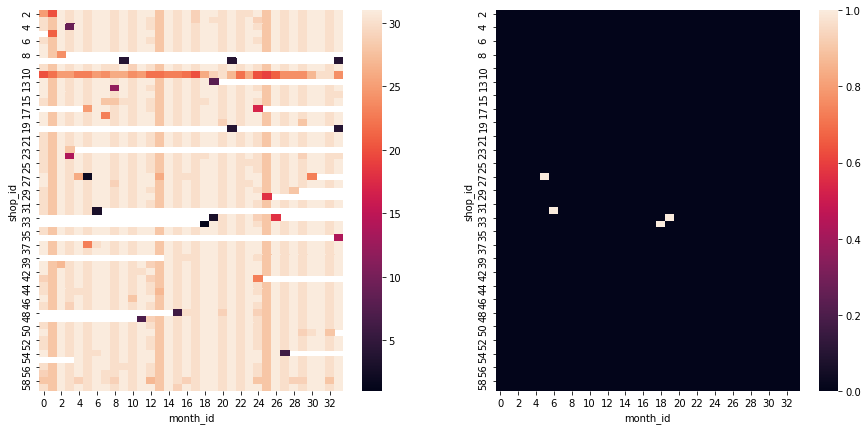

In [25]:
# the shops are generally open every day of the month
# on the opening and closing months, the shops are open less days
# shop 12 is open on average 77% of the days

fig,axes=plt.subplots(1,2,figsize=(15,7))
tmp=train_df[['date','month_id','shop_id']].groupby(['month_id','shop_id'])['date'].nunique().unstack().T
sns.heatmap(tmp,ax=axes[0])
sns.heatmap(tmp<=3,ax=axes[1])

In [26]:
print('item 11030 is sold on months : '+str(train_df.loc[(train_df['item_id']==11030),'month_id'].unique()))
print('item 20949 is sold on months : '+str(train_df.loc[(train_df['item_id']==20949),'month_id'].unique()))

train_df.loc[(train_df['shop_id']==34)&(train_df['month_id']==18)]

# only 2 items are sold on the opening month (month 18) for shop 34, each in only one copy
# these two items were sold in the past, and are sold later as well... we may just delete these two entries from the dataset!

item 11030 is sold on months : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
item 20949 is sold on months : [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33]


,date,month_id,shop_id,item_id,item_price,day_id,item_quantity
1861257,2014-07-31,18,34,11030,149.0,576,1.0
1861258,2014-07-31,18,34,20949,5.0,576,1.0


In [27]:
train_df.loc[(train_df['shop_id']==33)&(train_df['month_id']==19)]

,date,month_id,shop_id,item_id,item_price,day_id,item_quantity
1939987,2014-08-29,19,33,2252,599.00,605,1.0
1939988,2014-08-29,19,33,2355,2599.00,605,1.0
1939989,2014-08-29,19,33,3312,199.00,605,1.0
1939990,2014-08-29,19,33,8684,199.00,605,1.0
1939991,2014-08-29,19,33,10161,199.00,605,1.0
1939992,2014-08-29,19,33,12383,249.00,605,1.0
1939993,2014-08-29,19,33,13205,299.00,605,1.0
1939994,2014-08-29,19,33,13889,199.00,605,1.0
1939995,2014-08-29,19,33,19845,199.00,605,1.0
1939996,2014-08-29,19,33,21830,1199.00,605,1.0


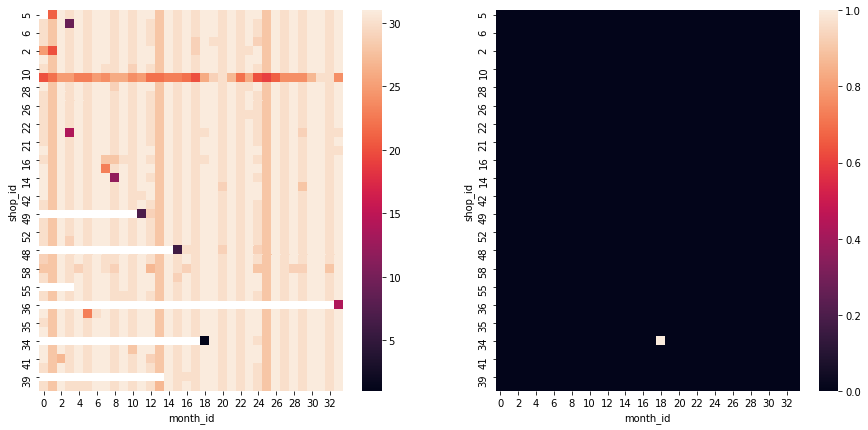

In [28]:
# restriction to shops that are present in the test set
fig,axes=plt.subplots(1,2,figsize=(15,7))
tmp_test=tmp.loc[test_df['shop_id'].unique(),:]
sns.heatmap(tmp_test,ax=axes[0])
sns.heatmap(tmp_test<=3,ax=axes[1])

In [29]:
del tmp, tmp_test
gc.collect()

9

### Remove outlier shops

In [30]:
# shop 9 and 20 are only open on October months (and only a few days within these months)
print(shops.loc[shops['shop_id']==9,'shop_name'].values)
print('shop 9 is for "out-bound trade", and it is only open on months 9,21 and 33')
print()
print(shops.loc[shops['shop_id']==20,'shop_name'].values)
print('shop 20 is for "Moscow sell-out" and is only open on months 21 and 33')

['Выездная Торговля']
shop 9 is for "out-bound trade", and it is only open on months 9,21 and 33

['Москва "Распродажа"']
shop 20 is for "Moscow sell-out" and is only open on months 21 and 33


In [31]:
# shop 12 and 55 are not physical shops: they appear in the test set so we do not discard them
print(shops.loc[shops['shop_id']==12,'shop_name'].values)
print('shop 12 is "emergency online shop" (appears in the test set as well)')
print()
print(shops.loc[shops['shop_id']==55,'shop_name'].values)
print('shop 55 is "digital warehouse 1C online" (appears in the test set as well)')

['Интернет-магазин ЧС']
shop 12 is "emergency online shop" (appears in the test set as well)

['Цифровой склад 1С-Онлайн']
shop 55 is "digital warehouse 1C online" (appears in the test set as well)


In [32]:
train_df.loc[train_df['shop_id']==9].info(null_counts=True)
print()
train_df.loc[train_df['shop_id']==20].info(null_counts=True)
print()
train_df.loc[train_df['shop_id']==12].info(null_counts=True)
print()
train_df.loc[train_df['shop_id']==55].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3743 entries, 935976 to 2881630
Data columns (total 7 columns):
date             3743 non-null datetime64[ns]
month_id         3743 non-null int64
shop_id          3743 non-null int64
item_id          3743 non-null int64
item_price       3743 non-null float64
day_id           3743 non-null int64
item_quantity    3743 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 233.9 KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1791 entries, 2024306 to 2882078
Data columns (total 7 columns):
date             1791 non-null datetime64[ns]
month_id         1791 non-null int64
shop_id          1791 non-null int64
item_id          1791 non-null int64
item_price       1791 non-null float64
day_id           1791 non-null int64
item_quantity    1791 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 111.9 KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34264 entries, 9024 to 2923809
Da

In [33]:
# we remove shops 9 and 20 as they are not open on continuous time periods and they likely behave differently from other shops and are not in the test set
shops.drop(9,axis=0,inplace=True)
shops.drop(20,axis=0,inplace=True)

train_df.drop(train_df.loc[train_df['shop_id']==9].index,axis=0,inplace=True)
train_df.drop(train_df.loc[train_df['shop_id']==20].index,axis=0,inplace=True)

In [34]:
# we remove shop 33 from the dataset: it is only open on a short period of time in the middle of the training period, it has 6 full months for 1 opening and 1 closing month...
shops.drop(33,axis=0,inplace=True)

train_df.drop(train_df.loc[train_df['shop_id']==33].index,axis=0,inplace=True)

In [35]:
# we remove the two entries for shop 34 on month 18, as only two items were sold in only one copy each
train_df.drop(train_df.loc[(train_df['shop_id']==34)&(train_df['month_id']==18)].index,axis=0,inplace=True)

### Visualization

In [36]:
shops

,shop_name,shop_id,city,city_id
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,4
10,Жуковский ул. Чкалова 39м?,10,Жуковский,6
12,Интернет-магазин ЧС,12,Интернет-магазин,7
13,"Казань ТЦ ""Бехетле""",13,Казань,8


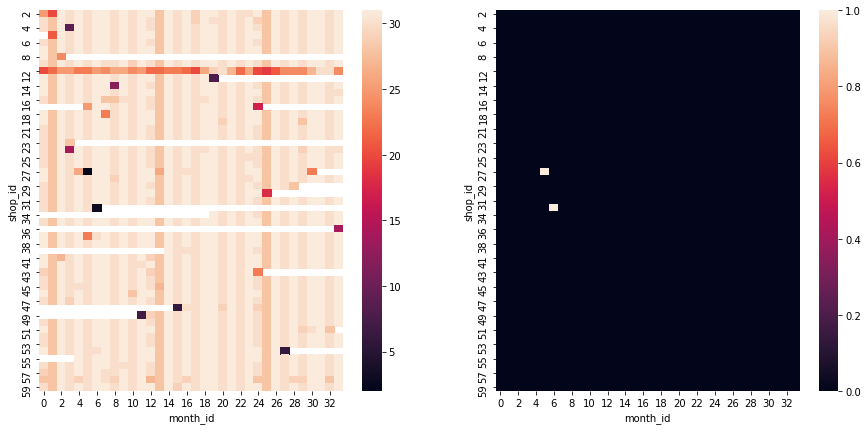

In [37]:
# opening days of shops after cleaning
fig,axes=plt.subplots(1,2,figsize=(15,7))
tmp=train_df[['date','month_id','shop_id']].groupby(['month_id','shop_id'])['date'].nunique().unstack().T
sns.heatmap(tmp,ax=axes[0])
sns.heatmap(tmp<=3,ax=axes[1])

In [38]:
# collect garbage
del tmp
gc.collect()

5

## PREPROCESSING OF ITEM_CATEGORIES

### Feature engineering

In [39]:
# Rename categories
item_categories.loc[0,'item_category_name']='Аксессуары - PC (Гарнитуры/Наушники)'
item_categories.loc[8,'item_category_name']='Билеты - Билеты (Цифра)'
item_categories.loc[9,'item_category_name']='Доставка товара - Доставка товара'
item_categories.loc[26,'item_category_name']='Игры - Android (Цифра)'
item_categories.loc[27,'item_category_name']='Игры - MAC (Цифра)'
item_categories.loc[28,'item_category_name']='Игры - PC (Дополнительные издания)'
item_categories.loc[29,'item_category_name']='Игры - PC (Коллекционные издания)'
item_categories.loc[30,'item_category_name']='Игры - PC (Стандартные издания)'
item_categories.loc[31,'item_category_name']='Игры - PC (Цифра)'
item_categories.loc[32,'item_category_name']='Карты оплаты - Кино, Музыка, Игры'
item_categories.loc[79,'item_category_name']='Прием денежных средств для 1С-Онлайн - Прием денежных средств для 1С-Онлайн'
item_categories.loc[80,'item_category_name']='Билеты - Билеты'
item_categories.loc[81,'item_category_name']='Misc - Чистые носители (шпиль)'
item_categories.loc[82,'item_category_name']='Misc - Чистые носители (штучные)'
item_categories.loc[83,'item_category_name']='Misc - Элементы питания'

In [40]:
# create feature item_supercategory_name, item_category_console, item_category_is_digital from item_category_name
item_categories['item_supercategory_name'] = item_categories['item_category_name'].str.extract('([\S\s]+)\s\-', expand=False)
item_categories['item_category_is_digital']=(item_categories['item_category_name'].str.find('(Цифра)')>=0)

consoles=['PS2','PS3','PS4','PSP','PSVita','XBOX 360','XBOX ONE','PC','MAC','Android']
item_categories['item_category_console']=''
for console in consoles:
    item_categories['item_category_console']+=item_categories['item_category_name'].str.extract('('+console+')',expand=False).fillna('')

item_categories.loc[item_categories['item_category_console']=='','item_category_console']='None'

print('cardinality of the supercategories : ' + str(item_categories['item_supercategory_name'].nunique()))
print('items in the null category : ' + str(item_categories['item_supercategory_name'].isnull().sum()))
print()
print('cardinality of the consoles : ' + str(item_categories['item_category_console'].nunique()))
print('items associated with no consoles : ' + str(item_categories['item_category_console'].isnull().sum()))
print()
print('cardinality of digital items : '+ str(item_categories['item_category_is_digital'].sum()))

cardinality of the supercategories : 13
items in the null category : 0

cardinality of the consoles : 11
items associated with no consoles : 0

cardinality of digital items : 10


In [41]:
# categories in training and test set
train_categories=sorted(train_df['item_id'].map(items['item_category_id']).unique())
print(str(len(train_categories)) + ' categories in the training set :')
print(train_categories)
print()

test_categories=sorted(test_df['item_id'].map(items['item_category_id']).unique())
print(str(len(test_categories)) + ' categories in the test set :')
print(test_categories)
print()

# display supercategories
print('number of supercategories : '+str(item_categories['item_supercategory_name'].nunique()))
print()
for supercat in item_categories['item_supercategory_name'].unique():
    print(supercat + ' : ' +str(item_categories.loc[item_categories['item_supercategory_name']==supercat,'item_category_id'].nunique()))
    print(item_categories.loc[item_categories['item_supercategory_name']==supercat,['item_category_id','item_category_name']])
    print()
    
# display categories and their features
item_categories

del train_categories, test_categories

84 categories in the training set :
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]

62 categories in the test set :
[0, 2, 3, 5, 6, 7, 9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 49, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]

number of supercategories : 13

Аксессуары : 8
   item_category_id                    item_category_name
0                 0  Аксессуары - PC (Гарнитуры/Наушники)
1                 1                      Аксессуары - PS2
2                 2                      Аксессуары - PS3
3                 3                      Аксессуары - PS4
4                 4     

### Analysis of item categories

In [42]:
train_df['item_category_id']=train_df['item_id'].map(items['item_category_id'])

In [43]:
def cat_analyse(cat_id):
    tmp=train_df.loc[(train_df['item_category_id']==cat_id)]

    print('category '+str(cat_id)+' : ' + str(item_categories.loc[cat_id,'item_category_name']))
    print('total number of sales : ' + str(tmp.count()[0]))
    print('dates : ' + tmp.date.min().strftime("%d.%m.%Y") + ' --- ' + tmp.date.max().strftime("%d.%m.%Y"))
    print('total number of items in the category: ' + str(items.loc[(items['item_category_id']==cat_id)].count()[0]))
    print('some of the items : ')
    print(items.loc[items['item_category_id']==cat_id,'item_name'].head(10))
    print()

    sns.relplot(data=tmp,x='month_id',y='item_quantity',kind='line',estimator=sum,ci=None,marker='o')

In [44]:
def cat_compare(cat_id_a,cat_id_b):
    tmp=train_df.loc[(train_df['item_category_id']==cat_id_a) | (train_df['item_category_id']==cat_id_b)]

    print('category '+str(cat_id_a)+' : ' + str(item_categories.loc[cat_id_a,'item_category_name']))
    print('total number of sales : ' + str(tmp.loc[(tmp['item_category_id']==cat_id_a)].count()[0]))
    print('dates : ' + tmp.loc[(tmp['item_category_id']==cat_id_a)].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp.loc[(tmp['item_category_id']==cat_id_a)].date.max().strftime("%d.%m.%Y"))
    print('total number of items in the category: ' + str(items.loc[(items['item_category_id']==cat_id_a)].count()[0]))
    print('list of items : ')
    print(items.loc[items['item_category_id']==cat_id_a,'item_name'])
    print()

    print('category '+str(cat_id_b)+' : ' + str(item_categories.loc[cat_id_b,'item_category_name']))
    print('total number of sales : ' + str(tmp.loc[(tmp['item_category_id']==cat_id_b)].count()[0]))
    print('dates : ' + tmp.loc[(tmp['item_category_id']==cat_id_b)].date.min().strftime("%d.%m.%Y") + ' --- ' + tmp.loc[(tmp['item_category_id']==cat_id_b)].date.max().strftime("%d.%m.%Y"))
    print('total number of items in the category: ' + str(items.loc[(items['item_category_id']==cat_id_b)].count()[0]))
    print('list of items : ')
    print(items.loc[items['item_category_id']==cat_id_b,'item_name'])
    print()

    sns.relplot(data=tmp,x='month_id',y='item_quantity',col='item_category_id',kind='line',estimator=sum,ci=None,marker='o')

category 8 : Билеты - Билеты (Цифра)
total number of sales : 1863
dates : 15.07.2014 --- 30.09.2015
total number of items in the category: 9
list of items : 
9241    Билет "ИгроМир 2014" (на один день (отдельно -...
9242    Билет "ИгроМир 2014" (на один день (отдельно -...
9243    Билет "ИгроМир 2014" - семейный до 4-х человек...
9245    Билет "ИгроМир 2015" - 2 октября 2015 (сайт) У...
9247    Билет "ИгроМир 2015" - 2 октября 2015 УПР [Циф...
9249    Билет "ИгроМир 2015" - 3 октября 2015 (сайт) У...
9251    Билет "ИгроМир 2015" - 3 октября 2015 УПР [Циф...
9253    Билет "ИгроМир 2015" - 4 октября 2015 (сайт) У...
9255    Билет "ИгроМир 2015" - 4 октября 2015 УПР [Циф...
Name: item_name, dtype: object

category 80 : Билеты - Билеты
total number of sales : 1324
dates : 27.04.2015 --- 30.09.2015
total number of items in the category: 6
list of items : 
9244    Билет "ИгроМир 2015" - 2 октября 2015 (сайт) [...
9246    Билет "ИгроМир 2015" - 2 октября 2015 [Цифрова...
9248    Билет "ИгроМи

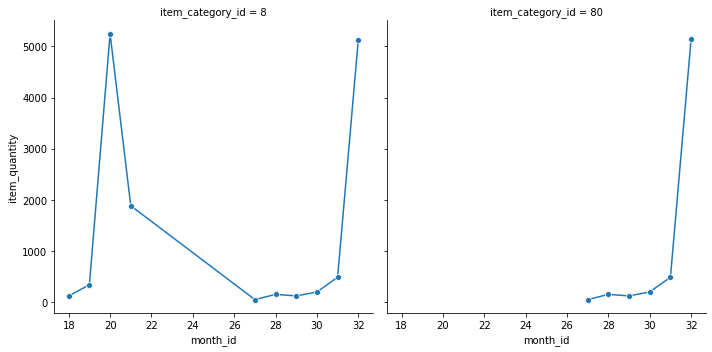

In [45]:
# Categories 8 and 80 are only for tickets for the GameWorld conference in October 2014 and 2015
# A significant part of the items between the two categories are actually duplicates!
cat_compare(8,80)

category 81 : Misc - Чистые носители (шпиль)
total number of sales : 794
dates : 01.01.2013 --- 26.03.2015
total number of items in the category: 7
list of items : 
13346    Компактдиск Mirex CD-R printable inkjet 48x Ca...
13347    Компактдиск Mirex CD-R printable inkjet 48x Ca...
13349     Компактдиск Mirex CD-RW 700 Мб 4-12x Cake box 10
13352    Компактдиск Mirex DVD+R Dual Layer printable i...
13355       Компактдиск Mirex DVD-R 4.7 Гб 16х Cake box 10
13356    Компактдиск Mirex DVD-R printable inkjet 4,7 Г...
13358       Компактдиск Mirex DVD-RW 4.7 Гб 4х Cake box 10
Name: item_name, dtype: object

category 82 : Misc - Чистые носители (штучные)
total number of sales : 4390
dates : 01.01.2013 --- 23.01.2015
total number of items in the category: 8
list of items : 
13344      Компактдиск Mirex CD-R 700 Мб 48x Slim case PRO
13345    Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...
13348      Компактдиск Mirex CD-RW 700 Мб 16-24x Slim case
13350       Компактдиск Mirex CD-RW 700 Мб 4-

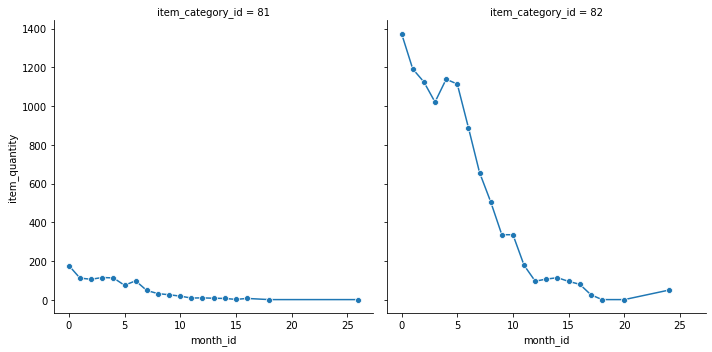

In [46]:
# Categories 81 and 82 are specific to "blank media" (CD-R,CD-RW,DVD-R,DVD-RW)
cat_compare(81,82)

category 79 : Прием денежных средств для 1С-Онлайн - Прием денежных средств для 1С-Онлайн
total number of sales : 9014
dates : 01.01.2013 --- 31.10.2015
total number of items in the category: 1
some of the items : 
17717    Прием денежных средств для 1С-Онлайн
Name: item_name, dtype: object



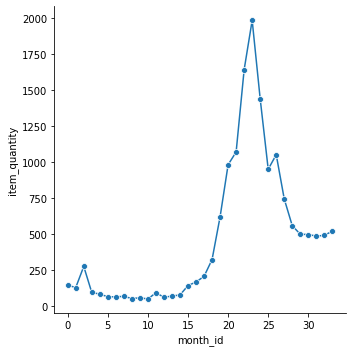

In [47]:
# Category 79 is specific to "Acceptance of funds for 1C-online"
cat_analyse(79)

category 9 : Доставка товара - Доставка товара
total number of sales : 2187
dates : 08.01.2013 --- 30.10.2015
total number of items in the category: 12
some of the items : 
11364                          Доставка (DHL)
11365                          Доставка (EMS)
11366                Доставка (Ваш Почтальон)
11367                Доставка (Клео-Логистик)
11368                       Доставка (Курьер)
11369                        Доставка (Почта)
11370                    Доставка (по Москве)
11371     Доставка Альтернативная (по Москве)
11372       Доставка до постомата (PickPoint)
11373    Доставка до пункта выдачи (Boxberry)
Name: item_name, dtype: object



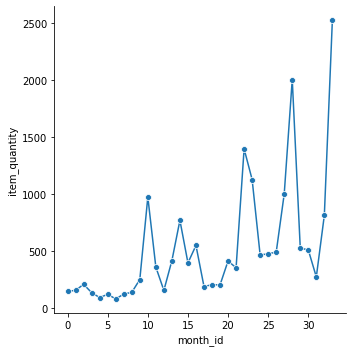

In [48]:
# Category 9 is specific to "Delivery"
# NB: this category is exclusively sold in shop 12 !
cat_analyse(9)

category 0 : Аксессуары - PC (Гарнитуры/Наушники)
total number of sales : 3
dates : 10.01.2013 --- 02.04.2013
total number of items in the category: 4
some of the items : 
5441     PC: Гарнитура HyperX Cloud Core игровая стерео...
16255                          Наушники PHILIPS SBC HC8680
16256                               Наушники RITMIX RH-120
16257                         Наушники RITMIX RH-124 Black
Name: item_name, dtype: object



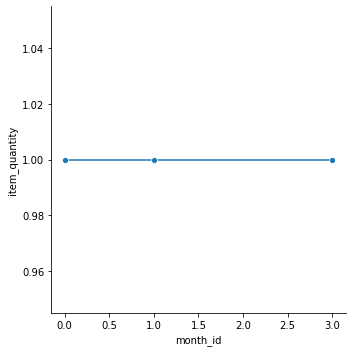

In [49]:
# Category 0 is specific to "Headphones"
cat_analyse(0)

category 83 : Misc - Элементы питания
total number of sales : 7164
dates : 01.01.2013 --- 31.10.2015
total number of items in the category: 15
some of the items : 
22085    Элемент питания DURACELL 123 A Ultra MP3 1*BL
22086           Элемент питания DURACELL 6LR61 9V 1*BL
22087                Элемент питания DURACELL LR03-BC2
22088                Элемент питания DURACELL LR06-BC2
22089               Элемент питания DURACELL LR14 2*BL
22090               Элемент питания DURACELL LR20 2*BL
22091        Элемент питания DURACELL TURBO LR 03 2*BL
22092          Элемент питания DURACELL TURBO LR6 2*BL
22093     Элемент питания GP 13A (LR20) - Блистер 2 шт
22094      Элемент питания GP 15A (LR6) - Блистер 2 шт
Name: item_name, dtype: object



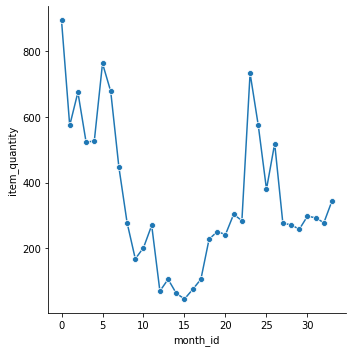

In [50]:
# Category 83 is specific to "Batteries"
cat_analyse(83)

### Drop irrelevant categories

In [51]:
# A significant part of the items between the two categories 8 and 80 seem to actually be duplicates (even though the shops don't match)
# Categories 8 and 80 are not in the test set so we might as well just ignore them

# Categories 81 and 82 are specific to "blank media" (CD-R,CD-RW,DVD-R,DVD-RW)
# Categories 81 and 82 are not in the test set so we might as well just ignore them

print('category  8 : ' + str(item_categories.loc[8,'item_category_name']))
print('category 80 : ' + str(item_categories.loc[80,'item_category_name']))
print('category 81 : ' + str(item_categories.loc[81,'item_category_name']))
print('category 82 : ' + str(item_categories.loc[82,'item_category_name']))

train_df.drop(train_df.loc[(train_df['item_id'].map(items['item_category_id'])==8)].index.values,axis=0,inplace=True)
train_df.drop(train_df.loc[(train_df['item_id'].map(items['item_category_id'])==80)].index.values,axis=0,inplace=True)
train_df.drop(train_df.loc[(train_df['item_id'].map(items['item_category_id'])==81)].index.values,axis=0,inplace=True)
train_df.drop(train_df.loc[(train_df['item_id'].map(items['item_category_id'])==82)].index.values,axis=0,inplace=True)

item_categories.drop(8,axis=0,inplace=True)
item_categories.drop(80,axis=0,inplace=True)
item_categories.drop(81,axis=0,inplace=True)
item_categories.drop(82,axis=0,inplace=True)

items.drop(items.loc[items['item_category_id']==8].index.values,axis=0,inplace=True)
items.drop(items.loc[items['item_category_id']==80].index.values,axis=0,inplace=True)
items.drop(items.loc[items['item_category_id']==81].index.values,axis=0,inplace=True)
items.drop(items.loc[items['item_category_id']==82].index.values,axis=0,inplace=True)

category  8 : Билеты - Билеты (Цифра)
category 80 : Билеты - Билеты
category 81 : Misc - Чистые носители (шпиль)
category 82 : Misc - Чистые носители (штучные)


In [52]:
# label encoding of item_category additional features
item_categories['item_supercategory_id']=item_categories['item_supercategory_name'].map({'Игровые консоли':0,'Игры':1,'Аксессуары':2,'Доставка товара':3,'Прием денежных средств для 1С-Онлайн':4,'Карты оплаты':5,'Кино':6,'Книги':7,'Музыка':8,'Подарки':9,'Программы':10,'Misc':11})
item_categories['item_category_console_id']=item_categories['item_category_console'].map({console:i for i,console in enumerate(consoles+['None'])})

In [53]:
# reorder columns
original_cols=['item_category_name','item_supercategory_name','item_category_console','item_category_is_digital']
label_cols=['item_category_id','item_supercategory_id','item_category_console_id']
item_categories=item_categories[original_cols+label_cols]

In [54]:
# join columns to training set
for col in original_cols:
    train_df[col]=train_df['item_category_id'].map(item_categories[col])
    
del original_cols
del label_cols

### Visualization

In [55]:
item_categories

,item_category_name,item_supercategory_name,item_category_console,item_category_is_digital,item_category_id,item_supercategory_id,item_category_console_id
0,Аксессуары - PC (Гарнитуры/Наушники),Аксессуары,PC,False,0,2,7
1,Аксессуары - PS2,Аксессуары,PS2,False,1,2,0
2,Аксессуары - PS3,Аксессуары,PS3,False,2,2,1
3,Аксессуары - PS4,Аксессуары,PS4,False,3,2,2
4,Аксессуары - PSP,Аксессуары,PSP,False,4,2,3
5,Аксессуары - PSVita,Аксессуары,PSVita,False,5,2,4
6,Аксессуары - XBOX 360,Аксессуары,XBOX 360,False,6,2,5
7,Аксессуары - XBOX ONE,Аксессуары,XBOX ONE,False,7,2,6
9,Доставка товара - Доставка товара,Доставка товара,None,False,9,3,10
10,Игровые консоли - PS2,Игровые консоли,PS2,False,10,0,0


In [56]:
# categories in training and test set
train_categories=sorted(train_df['item_id'].map(items['item_category_id']).unique())
print(str(len(train_categories)) + ' categories in the training set :')
print(train_categories)
print()

test_categories=sorted(test_df['item_id'].map(items['item_category_id']).unique())
print(str(len(test_categories)) + ' categories in the test set :')
print(test_categories)
print()

# display supercategories
print('number of supercategories : '+str(item_categories['item_supercategory_name'].nunique()))
print()
for supercat in item_categories['item_supercategory_name'].unique():
    print(supercat + ' : ' +str(item_categories.loc[item_categories['item_supercategory_name']==supercat,'item_category_id'].nunique()))
    print(item_categories.loc[item_categories['item_supercategory_name']==supercat,['item_category_id','item_category_name']])
    print()
    
# display consoles
print('number of consoles : '+str(item_categories['item_category_console'].nunique()))
print()
for console in item_categories['item_category_console'].unique():
    print(console + ' : ' +str(item_categories.loc[item_categories['item_category_console']==console,'item_category_id'].nunique()))
    print(item_categories.loc[item_categories['item_category_console']==console,['item_category_id','item_category_name']])
    print()
    
# display categories and their features
item_categories

del train_categories, test_categories

80 categories in the training set :
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]

62 categories in the test set :
[0, 2, 3, 5, 6, 7, 9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 49, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]

number of supercategories : 12

Аксессуары : 8
   item_category_id                    item_category_name
0                 0  Аксессуары - PC (Гарнитуры/Наушники)
1                 1                      Аксессуары - PS2
2                 2                      Аксессуары - PS3
3                 3                      Аксессуары - PS4
4                 4                    

In [57]:
# collect garbage
gc.collect()

19692

## PREPROCESSING OF THE PRICES

### Remove outliers in price data

In [58]:
max_price=train_df['item_price'].max()
most_expensive_item=train_df.loc[train_df['item_price']==max_price,'item_id'].values[0]
print('index of most expensive item : '+str(most_expensive_item))
print('price of most expensive item : '+str(max_price))
print('number of times where the most expensive item appears in training set : '+str(train_df.loc[train_df['item_id']==most_expensive_item].count()[0]))
print('most expensive item appears in test set : '+str(most_expensive_item in test_df['item_id'].values))

# We drop the outlier
train_df.drop(train_df['item_price'].idxmax(),axis=0,inplace=True)

del max_price, most_expensive_item

index of most expensive item : 6066
price of most expensive item : 307980.0
number of times where the most expensive item appears in training set : 1
most expensive item appears in test set : False


In [59]:
# Drop the realisation with negative price (there is only one, probably missing value)
print('number of realisation with negative prices : '+str((train_df['item_price']<0).sum()))
train_df.drop(train_df['item_price'].idxmin(),axis=0,inplace=True)
print('number of realisation with negative prices : '+str((train_df['item_price']<0).sum()))

number of realisation with negative prices : 1
number of realisation with negative prices : 0


In [60]:
# collect garbage
gc.collect()

0

## Format dataframes

In [61]:
# reduce training set to original columns only
train_df=train_df.iloc[:,0:7]
train_df.head()

,date,month_id,shop_id,item_id,item_price,day_id,item_quantity
0,2013-01-01,0,2,991,99.0,0,1.0
1,2013-01-01,0,2,1472,2599.0,0,1.0
2,2013-01-01,0,2,1905,249.0,0,1.0
3,2013-01-01,0,2,2920,599.0,0,2.0
4,2013-01-01,0,2,3320,1999.0,0,1.0


In [62]:
# downcast dtypes for all dataframes
downcast_dtypes(train_df)
train_df['month_id']=train_df['month_id'].astype(np.int8)
train_df['shop_id']=train_df['shop_id'].astype(np.int8)

downcast_dtypes(shops)
shops['shop_id']=shops['shop_id'].astype(np.int8)

downcast_dtypes(items)
items['item_category_id']=items['item_category_id'].astype(np.int8)

downcast_dtypes(item_categories)
item_categories['item_category_id']=item_categories['item_category_id'].astype(np.int8)

# collect garbage
gc.collect()

0

In [63]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [64]:
item_categories.head()

,item_category_name,item_supercategory_name,item_category_console,item_category_is_digital,item_category_id,item_supercategory_id,item_category_console_id
0,Аксессуары - PC (Гарнитуры/Наушники),Аксессуары,PC,False,0,2,7
1,Аксессуары - PS2,Аксессуары,PS2,False,1,2,0
2,Аксессуары - PS3,Аксессуары,PS3,False,2,2,1
3,Аксессуары - PS4,Аксессуары,PS4,False,3,2,2
4,Аксессуары - PSP,Аксессуары,PSP,False,4,2,3


In [65]:
shops.head()

,shop_name,shop_id,city,city_id
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,4


In [66]:
train_df.head()

,date,month_id,shop_id,item_id,item_price,day_id,item_quantity
0,2013-01-01,0,2,991,99.0,0,1.0
1,2013-01-01,0,2,1472,2599.0,0,1.0
2,2013-01-01,0,2,1905,249.0,0,1.0
3,2013-01-01,0,2,2920,599.0,0,2.0
4,2013-01-01,0,2,3320,1999.0,0,1.0


## Export data

In [67]:
print('TRAINING SET')
print()
print(train_df.dtypes)
print()
print('-----------')
print('SHOPS')
print()
print(shops.dtypes)
print()
print('-----------')
print('ITEMS')
print()
print(items.dtypes)
print()
print('-----------')
print('ITEM_CATEGORIES')
print()
print(item_categories.dtypes)

TRAINING SET

date             datetime64[ns]
month_id                   int8
shop_id                    int8
item_id                   int16
item_price              float32
day_id                    int16
item_quantity           float32
dtype: object

-----------
SHOPS

shop_name    object
shop_id        int8
city         object
city_id       int16
dtype: object

-----------
ITEMS

item_name           object
item_id              int16
item_category_id      int8
dtype: object

-----------
ITEM_CATEGORIES

item_category_name          object
item_supercategory_name     object
item_category_console       object
item_category_is_digital      bool
item_category_id              int8
item_supercategory_id        int16
item_category_console_id     int16
dtype: object


In [68]:
# create directory
create_directory(os.path.join(DATA_FOLDER, 'cleaned'))

# export data
train_df.to_pickle(os.path.join(DATA_FOLDER, 'cleaned/train.pkl'))
shops.to_pickle(os.path.join(DATA_FOLDER,'cleaned/shops.pkl'))
items.to_pickle(os.path.join(DATA_FOLDER,'cleaned/items.pkl'))
item_categories.to_pickle(os.path.join(DATA_FOLDER,'cleaned/item_categories.pkl'))

directory ../data/cleaned created succesfully !


In [69]:
# clear memory
del train_df
del shops
del items
del item_categories
del test_df

gc.collect()

0

In [70]:
reset_variable_space

## -------------------------------------------------------------

# 1 - MONTHLY AGGREGATION

- Aggregation of data at the monthly level
- Feature engineering at the monthly level

## Import data

In [71]:
train_df=pd.read_pickle(os.path.join(DATA_FOLDER,'cleaned/train.pkl'))
shops=pd.read_pickle(os.path.join(DATA_FOLDER,'cleaned/shops.pkl'))
items=pd.read_pickle(os.path.join(DATA_FOLDER,'cleaned/items.pkl'))
item_categories=pd.read_pickle(os.path.join(DATA_FOLDER,'cleaned/item_categories.pkl'))

In [72]:
# drop day identifier
train_df.drop('day_id',axis=1,inplace=True)

## EXTEND DATAFRAME TO PRODUCT SHOP x ITEMS EVERY MONTH

In [73]:
# aggregate sales data by (month,shop,item)
col_agg = ['month_id','shop_id','item_id']
train_agg=train_df.groupby(col_agg).agg(item_quantity=pd.NamedAgg(column='item_quantity',aggfunc='sum'))

train_agg.reset_index(inplace=True)
train_agg['month_id'] = train_agg['month_id'].astype(np.int8)
train_agg['shop_id'] = train_agg['shop_id'].astype(np.int8)
train_agg['item_id'] = train_agg['item_id'].astype(np.int16)

# true target values are clipped between 0 and 20, so do the same to training set
train_agg['item_quantity'].clip(0,20,inplace=True)

train_agg

,month_id,shop_id,item_id,item_quantity
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1599696,33,59,22087,6.0
1599697,33,59,22088,2.0
1599698,33,59,22091,1.0
1599699,33,59,22100,1.0


In [74]:
# import and format test set 
test_df=pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'test.csv'))
test_df['ID']=test_df['ID'].astype(np.int32)
test_df['shop_id']=test_df['shop_id'].astype(np.int8)
test_df['item_id']=test_df['item_id'].astype(np.int16)
test_df['month_id']=34
test_df=test_df[col_agg]

In [75]:
##################################################################################################################                             #
# For each month, we keep all pairs (shop,item) such that either shop or item is present in the original dataset #
##################################################################################################################

ts = time.time()

# build full multiindex
train_X = []
for i in range(0,34):
    sales = train_df.loc[train_df['month_id']==i]
    train_X.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))
    
# build dataframe from multiindex, downcast dtypes, and sort array
train_X = pd.DataFrame(np.vstack(train_X), columns=col_agg)
train_X = pd.concat([train_X,test_df],ignore_index=True)
train_X['month_id'] = train_X['month_id'].astype(np.int8)
train_X['shop_id'] = train_X['shop_id'].astype(np.int8)
train_X['item_id'] = train_X['item_id'].astype(np.int16)
train_X.sort_values(by=col_agg,inplace=True)

print('time : ' +str(time.time() - ts))
print()
print(train_X.info(null_counts=True))

del sales
gc.collect()

time : 10.098005056381226

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10905959 entries, 6608 to 10840136
Data columns (total 3 columns):
month_id    10905959 non-null int8
shop_id     10905959 non-null int8
item_id     10905959 non-null int16
dtypes: int16(1), int8(2)
memory usage: 124.8 MB
None


0

In [76]:
# ADD AGGREGATED SALES BY ( month, shop, item ) TO FULL DATAFRAME
ts = time.time()

# join aggregated data
train_X=train_X.join(train_agg.set_index(col_agg),on=col_agg)

# fill missing values for the item_quantity
train_X['item_quantity'].fillna(0,inplace=True)

# NB: the item_quantities for month 34 are all filled with 0 but in reality this quantity is unknown

print('time : ' +str(time.time() - ts))

time : 3.440469980239868


In [77]:
del col_agg
gc.collect()

0

## FEATURE ENGINEERING

In [78]:
# month of the year
train_X['month']=train_X['month_id']%12+1

In [79]:
# number of months since the shop has been opened
train_X['shop_months_since_opening']=train_X['month_id']-train_X['shop_id'].map(train_X[['month_id','shop_id']].groupby('shop_id').min()['month_id'])

# whether the shop is opening this month or not
train_X['shop_opening']=(train_X['shop_months_since_opening']==0)

In [80]:
# month where the item has been released (items released at certain times of the year are consistently less popular than those released at other times)
train_X['item_month_id_of_release']=train_X['item_id'].map(train_X[['month_id','item_id']].groupby('item_id').min()['month_id'])
train_X['item_month_of_release']=train_X['item_month_id_of_release']%12+1

# number of months since the item has been released
train_X['item_months_since_release']=train_X['month_id']-train_X['item_month_id_of_release']
train_X['item_months_since_release'].clip(0,12,inplace=True)  # group together items older than a year

# whether the item is new in the catalogue or not
train_X['item_new']=(train_X['item_months_since_release']==0)

In [81]:
# month where the item has first been sold in shop
train_X=train_X.join(train_agg[['shop_id','month_id','item_id']].groupby(['shop_id','item_id']).min().rename({'month_id':'item_month_id_of_first_sale_in_shop'},axis=1),on=['shop_id','item_id'])
train_X['item_month_of_first_sale_in_shop']=train_X['item_month_id_of_first_sale_in_shop']%12+1

# number of months since the item has been released in this shop
train_X['item_months_since_first_sale_in_shop']=(train_X['month_id']-train_X['item_month_id_of_first_sale_in_shop'])
train_X['item_months_since_first_sale_in_shop'].clip(0,12,inplace=True)  # group together items sold for more than a year in the shop

# whether the item has already been sold in this shop before or not
train_X['item_never_sold_in_shop_before']=~(train_X['item_months_since_first_sale_in_shop']>0)



# set month of release and number of months since the item has been released in this shop to -1 for all items never sold in shop before (remove info from future)
train_X.loc[train_X['item_never_sold_in_shop_before'],'item_months_since_first_sale_in_shop']=-1
train_X.loc[train_X['item_never_sold_in_shop_before'],'item_month_id_of_first_sale_in_shop']=-1
train_X.loc[train_X['item_never_sold_in_shop_before'],'item_month_of_first_sale_in_shop']=-1

# downcast dtype
train_X['item_months_since_first_sale_in_shop']=train_X['item_months_since_first_sale_in_shop'].astype(np.int8)
train_X['item_month_id_of_first_sale_in_shop']=train_X['item_month_id_of_first_sale_in_shop'].astype(np.int8)
train_X['item_month_of_first_sale_in_shop']=train_X['item_month_of_first_sale_in_shop'].astype(np.int8)

In [82]:
# indicator for items never sold in this shop, but already sold in other shops in the past
train_X['item_never_sold_in_shop_before_but_not_new']=((1-train_X['item_new'])*train_X['item_never_sold_in_shop_before']).astype(bool)

In [83]:
# label encode the 3 categories: 0-'new item', 1-'item never sold in shop but not new (ie sold in some other shops in the past)', 2-'item sold in shop in the past'
# <1  --> item never sold anywhere in the past  |   >=1 --> item sold in at least one shop in the past
# <2   --> item never sold in this shop before  |   >=2 --> item sold in this shop in the past

train_X['item_seniority']=(2-train_X['item_new'].astype(int)-train_X['item_never_sold_in_shop_before'].astype(int)).astype(np.int8)

In [84]:
###
# defined only for item_seniority==2

# compute month of most recent sale of item in shop
tmp_list=[]
for mid in train_X['month_id'].unique():
    tmp=train_agg.loc[train_agg['month_id']<mid,['month_id','shop_id','item_id']].groupby(['shop_id','item_id']).last().rename({'month_id':'item_month_id_of_last_sale_in_shop'},axis=1).astype(np.int16)
    tmp['month_id']=mid
    tmp.reset_index(inplace=True)
    tmp_list.append(tmp)
    
tmp=pd.concat(tmp_list)
del tmp_list
train_X=train_X.join(tmp.set_index(['month_id','shop_id','item_id']),on=['month_id','shop_id','item_id'])
del tmp

# downcast dtype (int not possible due to NaN values)
train_X['item_month_id_of_last_sale_in_shop']=train_X['item_month_id_of_last_sale_in_shop'].astype(np.float16)

# time since last sale in shop
train_X['item_months_since_last_sale_in_shop']=train_X['month_id']-train_X['item_month_id_of_last_sale_in_shop']

In [85]:
###
# defined only for item_seniority>=1

# compute month of most recent sale of item over all shops
tmp_list=[]
for mid in train_X['month_id'].unique():
    tmp=train_agg.loc[train_agg['month_id']<mid,['month_id','item_id']].groupby('item_id').last().rename({'month_id':'item_month_id_of_last_sale'},axis=1)
    tmp['month_id']=mid
    tmp.reset_index(inplace=True)
    tmp_list.append(tmp)
    
tmp=pd.concat(tmp_list)
del tmp_list
train_X=train_X.join(tmp.set_index(['month_id','item_id']),on=['month_id','item_id'])
del tmp

# downcast dtype (int not possible due to NaN values)
train_X['item_month_id_of_last_sale']=train_X['item_month_id_of_last_sale'].astype(np.float16)

# time since last sale over all shops
train_X['item_months_since_last_sale']=train_X['month_id']-train_X['item_month_id_of_last_sale']

In [86]:
# binary indicator for whether a pair has resulted in a sale or not (for feature generation later on)
train_X['item_sold_in_shop']=(train_X['item_quantity']>0)

In [87]:
# ADD PERMANENT FEATURES TO FULL DATAFRAME
ts=time.time()

train_X=train_X.join(shops.set_index('shop_id'),on='shop_id')
train_X=train_X.join(items.set_index('item_id'),on='item_id')
train_X=train_X.join(item_categories.set_index('item_category_id'),on='item_category_id')

print('time : ' +str(time.time() - ts))

gc.collect()

time : 4.566272974014282


0

In [88]:
# Frequency encodings (by month)
ts=time.time()

# NB: items and shops are evenly distributed each month in the global dataset

# monthly fraction of each category in the global catalogue
train_X=train_X.join(train_X.loc[:,['month_id','item_category_id']].groupby('month_id')['item_category_id'].value_counts(normalize=True).rename('item_category_freq',axis=1).astype(np.float32),on=['month_id','item_category_id'])
train_X=train_X.join(train_X.loc[:,['month_id','item_supercategory_id']].groupby('month_id')['item_supercategory_id'].value_counts(normalize=True).rename('item_supercategory_freq',axis=1).astype(np.float32),on=['month_id','item_supercategory_id'])
train_X=train_X.join(train_X.loc[:,['month_id','item_category_console_id']].groupby('month_id')['item_category_console_id'].value_counts(normalize=True).rename('item_category_console_freq',axis=1).astype(np.float32),on=['month_id','item_category_console_id'])
train_X=train_X.join(train_X.loc[:,['month_id','item_category_is_digital']].groupby('month_id')['item_category_is_digital'].value_counts(normalize=True).rename('item_category_digital_freq',axis=1).astype(np.float32),on=['month_id','item_category_is_digital'])

print('time : ' +str(time.time() - ts))

gc.collect()

time : 25.80979299545288


0

In [89]:
# Frequency encodings (by month / seniority)
ts=time.time()

# monthly fraction of items and shops in each seniority level
train_X=train_X.join(train_X.loc[:,['month_id','item_seniority','item_id']].groupby(['month_id','item_seniority'])['item_id'].value_counts(normalize=True).rename('item_freq_in_seniority',axis=1).astype(np.float32),on=['month_id','item_seniority','item_id'])
train_X=train_X.join(train_X.loc[:,['month_id','item_seniority','shop_id']].groupby(['month_id','item_seniority'])['shop_id'].value_counts(normalize=True).rename('shop_freq_in_seniority',axis=1).astype(np.float32),on=['month_id','item_seniority','shop_id'])

# monthly fraction of each category in each of the seniority level
train_X=train_X.join(train_X.loc[:,['month_id','item_seniority','item_category_id']].groupby(['month_id','item_seniority'])['item_category_id'].value_counts(normalize=True).rename('item_category_freq_in_seniority',axis=1).astype(np.float32),on=['month_id','item_seniority','item_category_id'])
train_X=train_X.join(train_X.loc[:,['month_id','item_seniority','item_supercategory_id']].groupby(['month_id','item_seniority'])['item_supercategory_id'].value_counts(normalize=True).rename('item_supercategory_freq_in_seniority',axis=1).astype(np.float32),on=['month_id','item_seniority','item_supercategory_id'])
train_X=train_X.join(train_X.loc[:,['month_id','item_seniority','item_category_console_id']].groupby(['month_id','item_seniority'])['item_category_console_id'].value_counts(normalize=True).rename('item_category_console_freq_in_seniority',axis=1).astype(np.float32),on=['month_id','item_seniority','item_category_console_id'])
train_X=train_X.join(train_X.loc[:,['month_id','item_seniority','item_category_is_digital']].groupby(['month_id','item_seniority'])['item_category_is_digital'].value_counts(normalize=True).rename('item_category_digital_freq_in_seniority',axis=1).astype(np.float32),on=['month_id','item_seniority','item_category_is_digital'])

print('time : ' +str(time.time() - ts))

gc.collect()

time : 45.56550979614258


0

In [90]:
print(train_X.info(null_counts=True))
train_X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10905959 entries, 6608 to 10840136
Data columns (total 43 columns):
month_id                                      10905959 non-null int8
shop_id                                       10905959 non-null int8
item_id                                       10905959 non-null int16
item_quantity                                 10905959 non-null float32
month                                         10905959 non-null int8
shop_months_since_opening                     10905959 non-null int8
shop_opening                                  10905959 non-null bool
item_month_id_of_release                      10905959 non-null int8
item_month_of_release                         10905959 non-null int8
item_months_since_release                     10905959 non-null int8
item_new                                      10905959 non-null bool
item_month_id_of_first_sale_in_shop           10905959 non-null int8
item_month_of_first_sale_in_shop              1090

,month_id,shop_id,item_id,item_quantity,month,shop_months_since_opening,shop_opening,item_month_id_of_release,item_month_of_release,item_months_since_release,...,item_category_freq,item_supercategory_freq,item_category_console_freq,item_category_digital_freq,item_freq_in_seniority,shop_freq_in_seniority,item_category_freq_in_seniority,item_supercategory_freq_in_seniority,item_category_console_freq_in_seniority,item_category_digital_freq_in_seniority
6608,0,2,19,0.0,1,0,True,0,1,0,...,0.295665,0.414598,0.853649,1.0,0.000124,0.022222,0.295665,0.414598,0.853649,1.0
1648,0,2,27,1.0,1,0,True,0,1,0,...,0.029023,0.133630,0.035569,1.0,0.000124,0.022222,0.029023,0.133630,0.035569,1.0
2359,0,2,28,0.0,1,0,True,0,1,0,...,0.051254,0.133630,0.064345,1.0,0.000124,0.022222,0.051254,0.133630,0.064345,1.0
4480,0,2,29,0.0,1,0,True,0,1,0,...,0.020748,0.133630,0.025071,1.0,0.000124,0.022222,0.020748,0.133630,0.025071,1.0
422,0,2,32,0.0,1,0,True,0,1,0,...,0.295665,0.414598,0.853649,1.0,0.000124,0.022222,0.295665,0.414598,0.853649,1.0


## PROCESS PRICE DATA

In [91]:
# expand sales to multiple rows to make statistics on the prices
train_df_expand=train_df.set_index(['month_id','shop_id','item_id'])['item_price']
train_df_expand=pd.DataFrame(train_df_expand.repeat(train_df['item_quantity']))
train_df_expand.reset_index(inplace=True)

# add values for the month 34 (useful for lagging values later on)
train_df_expand=pd.concat([train_df_expand,test_df],sort=False)

train_df_expand['item_category_id']=train_df_expand['item_id'].map(items['item_category_id'])
train_df_expand['item_supercategory_id']=train_df_expand['item_category_id'].map(item_categories['item_supercategory_id'])
train_df_expand['item_category_console_id']=train_df_expand['item_category_id'].map(item_categories['item_category_console_id'])

In [92]:
def encode_prices(groupby_labels,name):
    df_prices=train_df_expand.groupby(groupby_labels).agg({'item_price':['min','max','median','mean']})
    df_prices.columns=[name+'_price_'+col for col in df_prices.columns.get_level_values(1)]

    df_prices.reset_index(inplace=True)

    # downcast dtypes
    df_prices=downcast_dtypes(df_prices)
    
    return df_prices

def compare_to_super(df,df_super,join_labels,label,label_super,name,name_super,df_mapping):
    col_list=['price_min','price_max','price_median','price_mean']
    df[label_super]=df[label].map(df_mapping[label_super])
    df=df.join(df_super[join_labels+[label_super]+[name_super+'_'+col for col in col_list]].set_index(join_labels+[label_super]),on=join_labels+[label_super])
    df.drop(label_super,axis=1,inplace=True)
    for col in col_list:
        df[name_super+'_'+col]=df[name+'_'+col]/df[name_super+'_'+col]
        df.rename({name_super+'_'+col:name+'_'+col+'_compared_to_'+name_super+'_'+col},axis=1,inplace=True)

    # downcast dtypes
    df=downcast_dtypes(df)
    
    return df
    
def compare_to_lower(df,df_lower,label_lower,name,name_lower):
    col_list=['price_min','price_max','price_median','price_mean']
    df=df.join(df_lower[['month_id',label_lower]+[name_lower+'_'+col for col in col_list]].set_index(['month_id',label_lower]),on=['month_id',label_lower])
    for col in col_list:
        df[name_lower+'_'+col]=df[name+'_'+col]/df[name_lower+'_'+col]
        df.rename({name_lower+'_'+col:name+'_'+col+'_compared_to_'+name_lower+'_'+col},axis=1,inplace=True)

    # downcast dtypes
    df=downcast_dtypes(df)
    
    return df

In [93]:
# price data aggregated by (month,item_supercategory) (over all shops and items)
supercategory_prices=encode_prices(['month_id','item_supercategory_id'],'supercategory')

supercategory_prices['month_id'] = supercategory_prices['month_id'].astype(np.int8)

print(supercategory_prices.loc[supercategory_prices['month_id']<34,:].info(null_counts=True))
supercategory_prices

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 407
Data columns (total 6 columns):
month_id                      408 non-null int8
item_supercategory_id         408 non-null int16
supercategory_price_min       408 non-null float32
supercategory_price_max       408 non-null float32
supercategory_price_median    408 non-null float32
supercategory_price_mean      408 non-null float32
dtypes: float32(4), int16(1), int8(1)
memory usage: 10.8 KB
None


,month_id,item_supercategory_id,supercategory_price_min,supercategory_price_max,supercategory_price_median,supercategory_price_mean
0,0,0,4544.000000,15990.000000,13490.000000,12310.413086
1,0,1,14.000000,3999.000000,599.000000,880.393372
2,0,2,28.000000,12490.000000,1389.500000,1513.234497
3,0,3,97.800003,3170.000000,441.666656,657.778503
4,0,4,15.000000,1590.000000,299.000000,407.786194
5,0,5,487.000000,2500.000000,999.000000,1322.968262
6,0,6,21.600000,5999.000000,299.000000,348.613770
7,0,7,27.000000,3490.000000,299.000000,333.348694
8,0,8,22.400000,10999.000000,299.000000,322.610077
9,0,9,9.000000,13990.000000,399.000000,579.852966


In [94]:
# price data aggregated by (month,item_category) (over all shops and items)
category_prices=encode_prices(['month_id','item_category_id'],'category')
category_prices=compare_to_super(category_prices,supercategory_prices,['month_id'],'item_category_id','item_supercategory_id','category','supercategory',item_categories)

category_prices['month_id'] = category_prices['month_id'].astype(np.int8)

print(category_prices.loc[category_prices['month_id']<34,:].info(null_counts=True))
category_prices

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020 entries, 0 to 2019
Data columns (total 10 columns):
month_id                                                        2020 non-null int8
item_category_id                                                2020 non-null int16
category_price_min                                              2020 non-null float32
category_price_max                                              2020 non-null float32
category_price_median                                           2020 non-null float32
category_price_mean                                             2020 non-null float32
category_price_min_compared_to_supercategory_price_min          2020 non-null float32
category_price_max_compared_to_supercategory_price_max          2020 non-null float32
category_price_median_compared_to_supercategory_price_median    2020 non-null float32
category_price_mean_compared_to_supercategory_price_mean        2020 non-null float32
dtypes: float32(8), int16(1), int8(1)


,month_id,item_category_id,category_price_min,category_price_max,category_price_median,category_price_mean,category_price_min_compared_to_supercategory_price_min,category_price_max_compared_to_supercategory_price_max,category_price_median_compared_to_supercategory_price_median,category_price_mean_compared_to_supercategory_price_mean
0,0,0,148.0,148.0,148.0,148.000000,5.285714,0.011849,0.106513,0.097804
1,0,1,148.0,148.0,148.0,148.000000,5.285714,0.011849,0.106513,0.097804
2,0,2,294.0,6990.0,2298.0,2053.333008,10.500000,0.559648,1.653832,1.356917
3,0,3,242.0,2490.0,499.0,475.416992,8.642858,0.199359,0.359122,0.314173
4,0,4,28.0,2490.0,966.0,924.223511,1.000000,0.199359,0.695214,0.610760
...,...,...,...,...,...,...,...,...,...,...
2077,34,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2078,34,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2079,34,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2080,34,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# price data aggregated by (month,item) (over all shops)
item_prices=encode_prices(['month_id','item_id'],'item')
item_prices=compare_to_super(item_prices,category_prices,['month_id'],'item_id','item_category_id','item','category',items)

item_prices['month_id'] = item_prices['month_id'].astype(np.int8)

print(item_prices.loc[item_prices['month_id']<34,:].info(null_counts=True))
item_prices

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233073 entries, 0 to 233072
Data columns (total 10 columns):
month_id                                               233073 non-null int8
item_id                                                233073 non-null int16
item_price_min                                         233073 non-null float32
item_price_max                                         233073 non-null float32
item_price_median                                      233073 non-null float32
item_price_mean                                        233073 non-null float32
item_price_min_compared_to_category_price_min          233073 non-null float32
item_price_max_compared_to_category_price_max          233073 non-null float32
item_price_median_compared_to_category_price_median    233073 non-null float32
item_price_mean_compared_to_category_price_mean        233073 non-null float32
dtypes: float32(8), int16(1), int8(1)
memory usage: 9.6 MB
None


,month_id,item_id,item_price_min,item_price_max,item_price_median,item_price_mean,item_price_min_compared_to_category_price_min,item_price_max_compared_to_category_price_max,item_price_median_compared_to_category_price_median,item_price_mean_compared_to_category_price_mean
0,0,19,28.0,28.0,28.0,28.000000,1.296296,0.028028,0.112903,0.108192
1,0,27,1890.0,2499.0,2499.0,2325.000000,12.770270,0.624906,1.667111,1.481436
2,0,28,549.0,549.0,549.0,549.000000,39.214287,0.457882,1.222717,1.218184
3,0,29,1890.0,2499.0,2499.0,2377.199951,9.497487,0.624906,1.250125,1.286352
4,0,32,221.0,349.0,349.0,339.517914,10.231482,0.349349,1.407258,1.311891
...,...,...,...,...,...,...,...,...,...,...
238168,34,22162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238169,34,22163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238170,34,22164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238171,34,22166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# price data aggregated by (month,shop,item_supercategory) (over all items)
shop_supercategory_prices=encode_prices(['month_id','shop_id','item_supercategory_id'],'shop_supercategory')
shop_supercategory_prices=compare_to_lower(shop_supercategory_prices,supercategory_prices,'item_supercategory_id','shop_supercategory','supercategory')

shop_supercategory_prices['month_id'] = shop_supercategory_prices['month_id'].astype(np.int8)
shop_supercategory_prices['shop_id'] = shop_supercategory_prices['shop_id'].astype(np.int8)

print(shop_supercategory_prices.loc[shop_supercategory_prices['month_id']<34,:].info(null_counts=True))
shop_supercategory_prices

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15637 entries, 0 to 15636
Data columns (total 11 columns):
month_id                                                                  15637 non-null int8
shop_id                                                                   15637 non-null int8
item_supercategory_id                                                     15637 non-null int16
shop_supercategory_price_min                                              15637 non-null float32
shop_supercategory_price_max                                              15637 non-null float32
shop_supercategory_price_median                                           15637 non-null float32
shop_supercategory_price_mean                                             15637 non-null float32
shop_supercategory_price_min_compared_to_supercategory_price_min          15637 non-null float32
shop_supercategory_price_max_compared_to_supercategory_price_max          15637 non-null float32
shop_supercategory_price_m

,month_id,shop_id,item_supercategory_id,shop_supercategory_price_min,shop_supercategory_price_max,shop_supercategory_price_median,shop_supercategory_price_mean,shop_supercategory_price_min_compared_to_supercategory_price_min,shop_supercategory_price_max_compared_to_supercategory_price_max,shop_supercategory_price_median_compared_to_supercategory_price_median,shop_supercategory_price_mean_compared_to_supercategory_price_mean
0,0,2,0,4990.0,15990.0,13740.0,12154.974609,1.098151,1.000000,1.018532,0.987373
1,0,2,1,28.0,2999.0,599.0,916.976868,2.000000,0.749937,1.000000,1.041554
2,0,2,2,99.0,6990.0,1290.0,1545.719727,3.535714,0.559648,0.928392,1.021467
3,0,2,4,99.0,99.0,99.0,99.000000,6.600000,0.062264,0.331104,0.242774
4,0,2,5,999.0,1999.0,1999.0,1665.666626,2.051335,0.799600,2.001001,1.259037
...,...,...,...,...,...,...,...,...,...,...,...
16136,34,59,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16137,34,59,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16138,34,59,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16139,34,59,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# price data aggregated by (month,shop,item_category) (over all items)
shop_category_prices=encode_prices(['month_id','shop_id','item_category_id'],'shop_category')
shop_category_prices=compare_to_lower(shop_category_prices,category_prices,'item_category_id','shop_category','category')
shop_category_prices=compare_to_super(shop_category_prices,shop_supercategory_prices,['month_id','shop_id'],'item_category_id','item_supercategory_id','shop_category','shop_supercategory',item_categories)

shop_category_prices['month_id'] = shop_category_prices['month_id'].astype(np.int8)
shop_category_prices['shop_id'] = shop_category_prices['shop_id'].astype(np.int8)

print(shop_category_prices.loc[shop_category_prices['month_id']<34,:].info(null_counts=True))
shop_category_prices

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63950 entries, 0 to 63949
Data columns (total 15 columns):
month_id                                                                  63950 non-null int8
shop_id                                                                   63950 non-null int8
item_category_id                                                          63950 non-null int16
shop_category_price_min                                                   63950 non-null float32
shop_category_price_max                                                   63950 non-null float32
shop_category_price_median                                                63950 non-null float32
shop_category_price_mean                                                  63950 non-null float32
shop_category_price_min_compared_to_category_price_min                    63950 non-null float32
shop_category_price_max_compared_to_category_price_max                    63950 non-null float32
shop_category_price_median

,month_id,shop_id,item_category_id,shop_category_price_min,shop_category_price_max,shop_category_price_median,shop_category_price_mean,shop_category_price_min_compared_to_category_price_min,shop_category_price_max_compared_to_category_price_max,shop_category_price_median_compared_to_category_price_median,shop_category_price_mean_compared_to_category_price_mean,shop_category_price_min_compared_to_shop_supercategory_price_min,shop_category_price_max_compared_to_shop_supercategory_price_max,shop_category_price_median_compared_to_shop_supercategory_price_median,shop_category_price_mean_compared_to_shop_supercategory_price_mean
0,0,2,2,550.020020,3790.0,1590.000000,1979.846924,1.870816,0.542203,0.691906,0.964211,5.555758,0.542203,1.232558,1.280858
1,0,2,3,499.000000,499.0,499.000000,499.000000,2.061984,0.200402,1.000000,1.049605,5.040404,0.071388,0.386822,0.322827
2,0,2,4,99.000000,1990.0,1290.000000,913.599976,3.535714,0.799197,1.335404,0.988505,1.000000,0.284692,1.000000,0.591052
3,0,2,5,279.299988,3490.0,664.150024,1113.520020,2.738235,1.000000,0.950143,1.102451,2.821212,0.499285,0.514845,0.720389
4,0,2,6,499.000000,6990.0,1740.000000,2277.083252,1.897338,0.559648,1.167785,1.332426,5.040404,1.000000,1.348837,1.473154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66549,34,59,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66550,34,59,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66551,34,59,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66552,34,59,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
shop_item_prices=encode_prices(['month_id','shop_id','item_id'],'shop_item')
shop_item_prices=compare_to_lower(shop_item_prices,item_prices,'item_id','shop_item','item')
shop_item_prices=compare_to_super(shop_item_prices,shop_category_prices,['month_id','shop_id'],'item_id','item_category_id','shop_item','shop_category',items)


shop_item_prices['month_id'] = shop_item_prices['month_id'].astype(np.int8)
shop_item_prices['shop_id'] = shop_item_prices['shop_id'].astype(np.int8)

print(shop_item_prices.loc[shop_item_prices['month_id']<34,:].info(null_counts=True))
shop_item_prices

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599701 entries, 0 to 1599700
Data columns (total 15 columns):
month_id                                                         1599701 non-null int8
shop_id                                                          1599701 non-null int8
item_id                                                          1599701 non-null int16
shop_item_price_min                                              1599701 non-null float32
shop_item_price_max                                              1599701 non-null float32
shop_item_price_median                                           1599701 non-null float32
shop_item_price_mean                                             1599701 non-null float32
shop_item_price_min_compared_to_item_price_min                   1599701 non-null float32
shop_item_price_max_compared_to_item_price_max                   1599701 non-null float32
shop_item_price_median_compared_to_item_price_median             1599701 non-null flo

,month_id,shop_id,item_id,shop_item_price_min,shop_item_price_max,shop_item_price_median,shop_item_price_mean,shop_item_price_min_compared_to_item_price_min,shop_item_price_max_compared_to_item_price_max,shop_item_price_median_compared_to_item_price_median,shop_item_price_mean_compared_to_item_price_mean,shop_item_price_min_compared_to_shop_category_price_min,shop_item_price_max_compared_to_shop_category_price_max,shop_item_price_median_compared_to_shop_category_price_median,shop_item_price_mean_compared_to_shop_category_price_mean
0,0,2,27,2499.0,2499.0,2499.0,2499.0,1.322222,1.0,1.0,1.074839,5.559511,0.892819,1.667111,1.673472
1,0,2,33,499.0,499.0,499.0,499.0,1.438040,1.0,1.0,1.020381,7.258182,0.249625,1.000000,0.922298
2,0,2,317,299.0,299.0,299.0,299.0,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000
3,0,2,438,299.0,299.0,299.0,299.0,1.845679,1.0,1.0,1.100884,1.000000,1.000000,1.000000,1.000000
4,0,2,471,399.0,399.0,399.0,399.0,1.000000,1.0,1.0,1.000000,1.662500,1.000000,1.109875,1.170946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813896,34,59,22162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1813897,34,59,22163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1813898,34,59,22164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1813899,34,59,22166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Export data

In [99]:
# create directories
create_directory(os.path.join(DATA_FOLDER, 'processed'))
create_directory(os.path.join(DATA_FOLDER, 'processed/price_features'))

# export data
train_X.to_pickle(os.path.join(DATA_FOLDER,'processed/train_X0.pkl'))

shop_item_prices.to_pickle(os.path.join(DATA_FOLDER,'processed/price_features/shop_item_prices.pkl'))
item_prices.to_pickle(os.path.join(DATA_FOLDER,'processed/price_features/item_prices.pkl'))
shop_category_prices.to_pickle(os.path.join(DATA_FOLDER,'processed/price_features/shop_category_prices.pkl'))
category_prices.to_pickle(os.path.join(DATA_FOLDER,'processed/price_features/category_prices.pkl'))
shop_supercategory_prices.to_pickle(os.path.join(DATA_FOLDER,'processed/price_features/shop_supercategory_prices.pkl'))
supercategory_prices.to_pickle(os.path.join(DATA_FOLDER,'processed/price_features/supercategory_prices.pkl'))

directory ../data/processed created succesfully !
directory ../data/processed/price_features created succesfully !


In [100]:
# clear memory
del items
del item_categories
del shops
del train_df
del train_df_expand
del train_agg
del train_X

del shop_item_prices
del item_prices
del shop_category_prices
del category_prices
del shop_supercategory_prices
del supercategory_prices


gc.collect()

0

In [101]:
reset_variable_space

## -------------------------------------------------------------

# 2 - EXPLORATORY DATA ANALYSIS

## Import data

In [102]:
train_X=pd.read_pickle(os.path.join(DATA_FOLDER,'processed/train_X0.pkl'))

# restrict to training set
train_X=train_X[train_X['month_id']<34]

## ANALYSE TARGET DISTRIBUTIONS IN THE TRAINING SET

### Total monthly sales

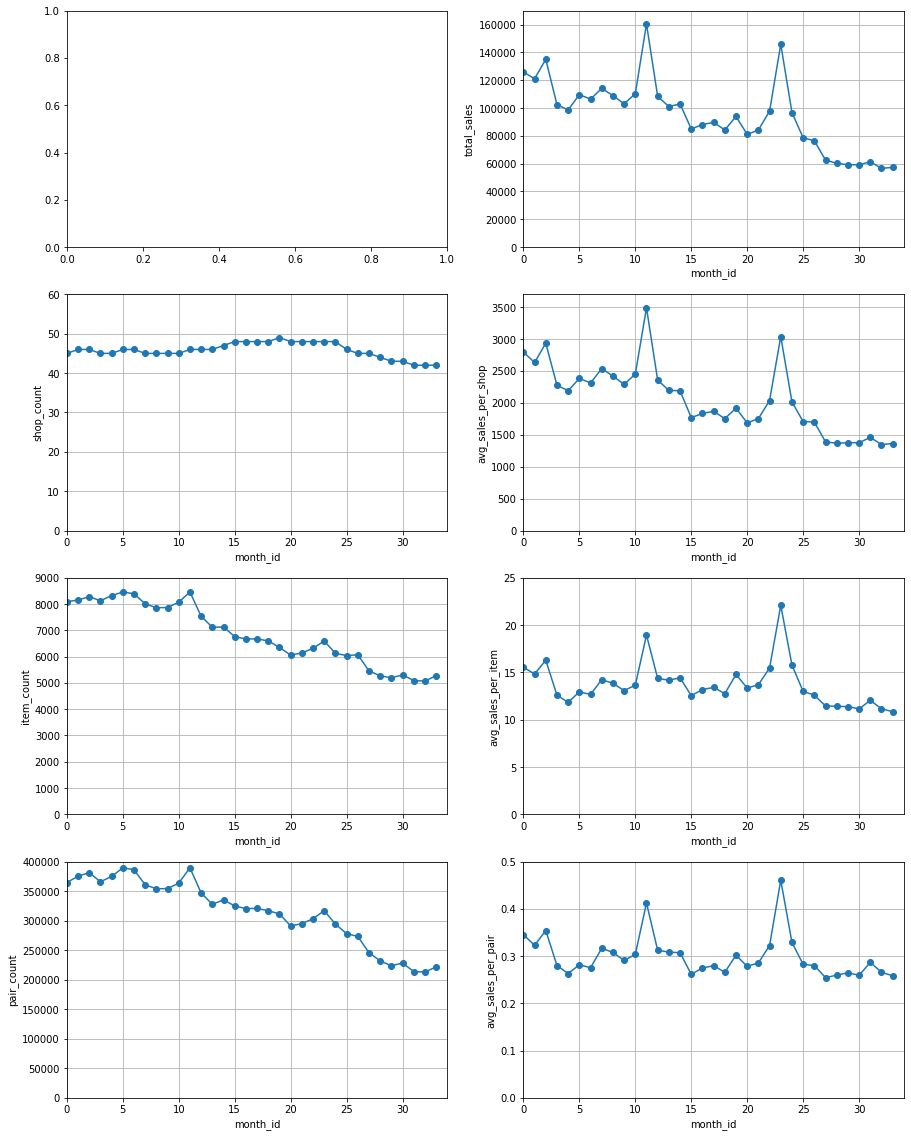

In [103]:
# Analyse total monthly sales
tmp_sales=train_X.loc[:,['month_id','shop_id','item_id','item_quantity']]
tmp_sales['item_quantity']=tmp_sales['item_quantity'].astype(np.float32)

tmp=pd.DataFrame()
tmp['total_sales_per_month']=tmp_sales[['month_id','item_quantity']].groupby('month_id').sum()['item_quantity']
tmp['shop_count']=tmp_sales[['month_id','shop_id']].groupby('month_id').nunique()['shop_id']
tmp['item_count']=tmp_sales[['month_id','item_id']].groupby('month_id').nunique()['item_id']
tmp['avg_sales_per_shop']=tmp['total_sales_per_month']/tmp['shop_count']
tmp['avg_sales_per_item']=tmp['total_sales_per_month']/tmp['item_count']
tmp['pair_count']=tmp['shop_count']*tmp['item_count']
tmp['avg_sales_per_pair']=tmp['total_sales_per_month']/tmp['pair_count']

fig,axes=plt.subplots(4,2,figsize=(15,20))

axes[0,1].plot(tmp['total_sales_per_month'],'-o')
axes[0,1].set_xlim(0,34)
axes[0,1].set_ylim(0,170000)
axes[0,1].grid(True)
axes[0,1].set_xlabel('month_id')
axes[0,1].set_ylabel('total_sales')

axes[1,0].plot(tmp['shop_count'],'-o')
axes[1,0].set_xlim(0,34)
axes[1,0].set_ylim(0,60)
axes[1,0].grid(True)
axes[1,0].set_xlabel('month_id')
axes[1,0].set_ylabel('shop_count')

axes[1,1].plot(tmp['avg_sales_per_shop'],'-o')
axes[1,1].set_xlim(0,34)
axes[1,1].set_ylim(0,3700)
axes[1,1].grid(True)
axes[1,1].set_xlabel('month_id')
axes[1,1].set_ylabel('avg_sales_per_shop')

axes[2,0].plot(tmp['item_count'],'-o')
axes[2,0].set_xlim(0,34)
axes[2,0].set_ylim(0,9000)
axes[2,0].grid(True)
axes[2,0].set_xlabel('month_id')
axes[2,0].set_ylabel('item_count')

axes[2,1].plot(tmp['avg_sales_per_item'],'-o')
axes[2,1].set_xlim(0,34)
axes[2,1].set_ylim(0,25)
axes[2,1].grid(True)
axes[2,1].set_xlabel('month_id')
axes[2,1].set_ylabel('avg_sales_per_item')

axes[3,0].plot(tmp['pair_count'],'-o')
axes[3,0].set_xlim(0,34)
axes[3,0].set_ylim(0,400000)
axes[3,0].grid(True)
axes[3,0].set_xlabel('month_id')
axes[3,0].set_ylabel('pair_count')

axes[3,1].plot(tmp['avg_sales_per_pair'],'-o')
axes[3,1].set_xlim(0,34)
axes[3,1].set_ylim(0,0.5)
axes[3,1].grid(True)
axes[3,1].set_xlabel('month_id')
axes[3,1].set_ylabel('avg_sales_per_pair')

del tmp_sales,tmp,fig,axes

The globally decreasing trend of the total sales over time is mostly due to the decreasing amount of items in the catalogue. The number of shops open remains roughly the same, and the average sales per item as well, except for the December peaks (months 11 and 23)

The December peaks should therefore imply a different distribution of the target distributions among the values 0,1,...,20. In December, the repartition should have more realisations in the classes with higher values compared to other months.

Apart from December, the average amount of sales per item in the catalogue remain roughly the same over all months.

### Distribution of target value

percentages
item_quantity        0.0        1.0        2.0        3.0        4.0
count          34.000000  34.000000  34.000000  34.000000  34.000000
mean           85.113460   9.837310   2.473175   0.957727   0.492150
std             1.139589   0.553991   0.241636   0.145769   0.093395
min            81.539501   9.130196   2.193290   0.805713   0.370709
max            86.641844  11.528001   3.301952   1.539059   0.853665
item_quantity        5.0        6.0        7.0        8.0        9.0
count          34.000000  34.000000  34.000000  34.000000  34.000000
mean            0.292801   0.189334   0.127725   0.094129   0.067818
std             0.062641   0.048217   0.034425   0.029070   0.020899
min             0.209567   0.124519   0.084234   0.059004   0.043541
max             0.535750   0.363691   0.248144   0.204261   0.143330
item_quantity       10.0       11.0       12.0       13.0       14.0
count          34.000000  34.000000  34.000000  34.000000  34.000000
mean            0.0541

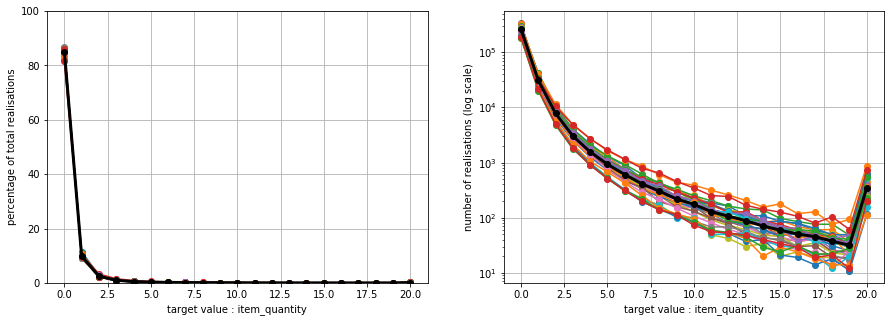

In [104]:
# Compare distributions of the target value 'item_quantity' in dataset between all months
df_count=train_X[['month_id','item_quantity']].groupby('month_id')['item_quantity'].value_counts()
df_count=df_count.unstack()

df_percentage=train_X[['month_id','item_quantity']].groupby('month_id')['item_quantity'].value_counts(normalize=True)
df_percentage=df_percentage.unstack()*100

a=df_count.values
b=df_percentage.values

print('percentages')
print(df_percentage.iloc[:,0:5].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,5:10].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,10:15].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,15:].describe(percentiles=[]).drop('50%',axis=0))
print()
print('counts')
print(df_count.iloc[:,0:4].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,4:8].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,8:12].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,12:16].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,16:].describe(percentiles=[]).drop('50%',axis=0))

fig,axes=plt.subplots(1,2,figsize=(15,5))
axes[0].plot(b.T,'-o')
axes[0].plot(b.mean(axis=0),'-ok',linewidth=3)
axes[0].set_xlabel('target value : item_quantity')
axes[0].set_ylabel('percentage of total realisations')
axes[0].grid(True)
axes[0].set_ylim(0,100)

axes[1].plot(a.T,'-o')
axes[1].plot(a.mean(axis=0),'-ok',linewidth=3)
axes[1].set_xlabel('target value : item_quantity')
axes[1].set_ylabel('number of realisations (log scale)')
axes[1].grid(True)
axes[1].set_yscale('log')

del axes,fig

# The distribution of the target value is similar every month
# Clipping the values above 20 together will result in about 100-900 realisations in the class item_quantity = 20
# Then, the amount of realisations with value 19 (lowest populated category after clipping) varies around 10-100

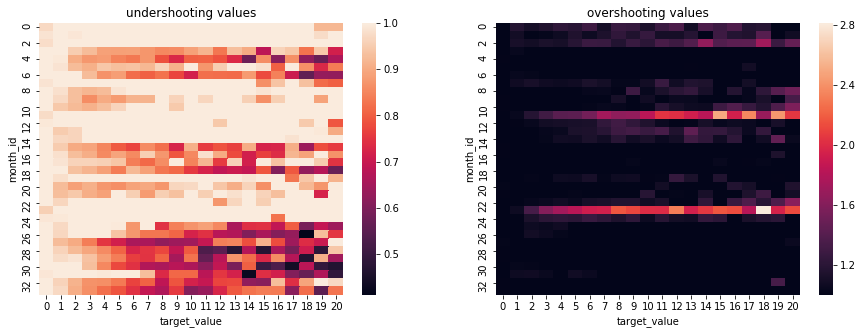

In [105]:
# compare the distribution to its mean over all months
# threshold the comparison at 1 to focus on under/overshooting values (set all values below threshold to 'threshold')
b_over=b/b.mean(axis=0)
b_under=b/b.mean(axis=0)
thres=1       # here threshold=1
b_over[b_over<thres]=thres
b_under[b_under>thres]=thres

fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.heatmap(b_under,ax=axes[0])
axes[0].set_title('undershooting values')
axes[0].set_ylabel('month_id')
axes[0].set_xlabel('target_value')
sns.heatmap(b_over,ax=axes[1])
axes[1].set_title('overshooting values')
axes[1].set_ylabel('month_id')
axes[1].set_xlabel('target_value')

del fig

# the distribution of target variable is clearly moved towards the larger values in December
# in December, the larger values may be up to 2.7 more frequent than on average !!
# the frequency of the low values varies very little from month to month

# November appears like a fairly average month!

In [106]:
del a,b,b_over,b_under,df_count,df_percentage
gc.collect()

15

## ANALYSIS BY SENIORITY LEVEL

In [107]:
# repartition of seniority levels in the dataset each month
tmp=pd.read_pickle(os.path.join(DATA_FOLDER,'processed/train_X0.pkl'))

tmp=tmp[['month_id','item_seniority']].groupby('month_id')['item_seniority'].value_counts(normalize=True).unstack()

print(tmp)

del tmp

item_seniority         0         1         2
month_id                                    
0               1.000000       NaN       NaN
1               0.151894  0.685703  0.162403
2               0.096284  0.660268  0.243448
3               0.077254  0.606329  0.316417
4               0.081902  0.573687  0.344411
5               0.062611  0.571545  0.365844
6               0.053246  0.546977  0.399777
7               0.058523  0.510304  0.431173
8               0.048824  0.492655  0.458521
9               0.065549  0.465633  0.468818
10              0.060782  0.464009  0.475208
11              0.064154  0.470132  0.465714
12              0.028249  0.455507  0.516244
13              0.047880  0.422118  0.530002
14              0.044027  0.431692  0.524281
15              0.047288  0.427913  0.524799
16              0.039395  0.422371  0.538234
17              0.037880  0.420659  0.541461
18              0.047417  0.399520  0.553063
19              0.039654  0.416824  0.543522
20        

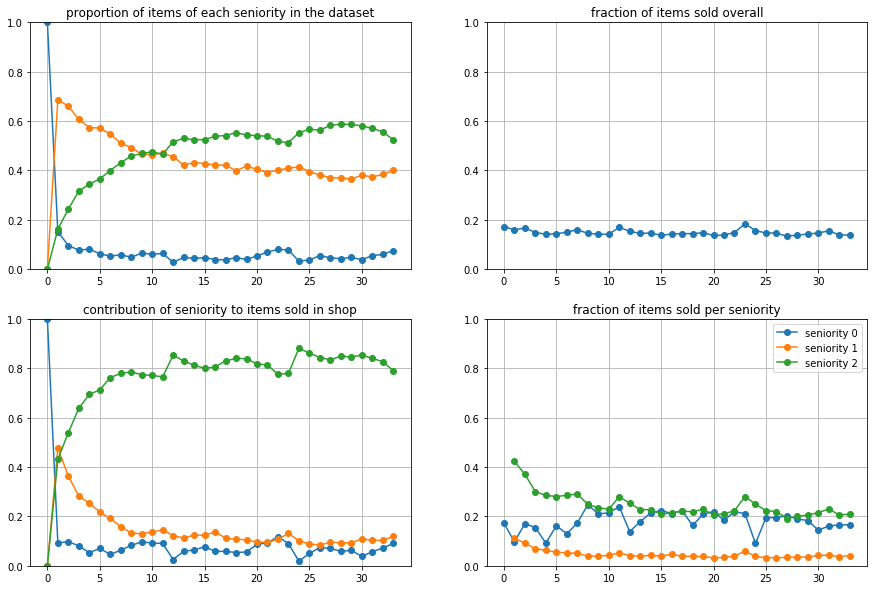

In [108]:
# Assess variations of sales between seniority levels
tmp=train_X.loc[:,['month_id','item_seniority','item_sold_in_shop']]

tmp['all']=1

tmp['seniority_0']=(tmp['item_seniority']==0)
tmp['seniority_1']=(tmp['item_seniority']==1)
tmp['seniority_2']=(tmp['item_seniority']==2)

tmp['sold_0']=tmp['item_sold_in_shop']&tmp['seniority_0']
tmp['sold_1']=tmp['item_sold_in_shop']&tmp['seniority_1']
tmp['sold_2']=tmp['item_sold_in_shop']&tmp['seniority_2']



tmp_count=tmp[['month_id','seniority_0','seniority_1','seniority_2','sold_0','sold_1','sold_2','item_sold_in_shop','all']].groupby('month_id').sum()

fig,axes=plt.subplots(2,2,figsize=(15,10))
axes[0,0].plot(tmp_count['seniority_0']/tmp_count['all'],'-o')
axes[0,0].plot(tmp_count['seniority_1']/tmp_count['all'],'-o')
axes[0,0].plot(tmp_count['seniority_2']/tmp_count['all'],'-o')
axes[0,0].grid(True)
axes[0,0].set_ylim(0,1)
axes[0,0].set_title('proportion of items of each seniority in the dataset')

axes[0,1].plot(tmp_count['item_sold_in_shop']/tmp_count['all'],'-o')
axes[0,1].grid(True)
axes[0,1].set_ylim(0,1)
axes[0,1].set_title('fraction of items sold overall')

axes[1,0].plot(tmp_count['sold_0']/tmp_count['item_sold_in_shop'],'-o')
axes[1,0].plot(tmp_count['sold_1']/tmp_count['item_sold_in_shop'],'-o')
axes[1,0].plot(tmp_count['sold_2']/tmp_count['item_sold_in_shop'],'-o')
axes[1,0].grid(True)
axes[1,0].set_ylim(0,1)
axes[1,0].set_title('contribution of seniority to items sold in shop')

axes[1,1].plot(tmp_count['sold_0']/tmp_count['seniority_0'],'-o')
axes[1,1].plot(tmp_count['sold_1']/tmp_count['seniority_1'],'-o')
axes[1,1].plot(tmp_count['sold_2']/tmp_count['seniority_2'],'-o')
axes[1,1].grid(True)
axes[1,1].set_ylim(0,1)
axes[1,1].set_title('fraction of items sold per seniority')
axes[1,1].legend(['seniority 0','seniority 1','seniority 2'])

del fig,axes,tmp,tmp_count

# among all items, the pairs (shop,item) are distributed approximately:
    # ~ 5%  in seniority 0
    # ~ 40% in seniority 1
    # ~ 55% in seniority 2
    
# among the items sold:
    # ~5% in seniority 0
    # ~12% in seniority 1
    # ~83% in seniority 2
    
# every month, the proportion of pairs (shop,item) that are sold is aproximately
    # ~15% overall
    # ~15-20% in seniority 0
    # ~5% in seniority 1
    # ~20-25% in seniority 2

3 situations may occur, and it is probably best to think of 3 different models for each of these categories!

1) the item has previously been sold in this shop (seniority = 2)
- This category covers about 50-60% of the dataset
- We are able to use information about past sales for this pair (shop, item) to predict future sales

2) the item has never been sold in this shop, but it was already in the global catalogue before  (seniority = 1)
- This category covers about 40-50% of the dataset each month
- From the above analysis, such a pair (shop,item) has around 95% chance not to result in any sales this month either, so estimating their sales to 0 should be correct for 95% of them, and wrong for about 5% of them
- We have no past data for this pair (shop,item), but we have past data for this item in other shops where it was sold.

3) the item is new in the global catalogue  (seniority = 0)
- This category covers roughly between 2.5 and 10% of all realisations in the dataset
- There is no past data for this item, so we must estimate the sales of this item based on the sales of similar items when they were released.

NB: All items are assumed new on the first months because we do not have data from earlier months. This causes the repartition of items among the different categories to be misestimated for about the first 12 months.

In [109]:
# drop first 12 months
train_X.drop(train_X.loc[train_X['month_id']<12].index,axis=0,inplace=True)

### Distribution of target value for each seniority level

percentages
item_quantity        0.0        1.0        2.0        3.0        4.0
count          22.000000  22.000000  22.000000  22.000000  22.000000
mean           81.417623   8.984147   3.257981   1.676465   0.997312
std             3.332792   1.126840   0.626479   0.382465   0.295767
min            77.626812   5.659204   1.409619   0.735904   0.435323
max            90.972222  11.034256   4.133729   2.119600   1.453012
item_quantity        5.0        6.0        7.0        8.0        9.0
count          22.000000  22.000000  22.000000  22.000000  22.000000
mean            0.692682   0.477557   0.354297   0.304836   0.225411
std             0.200925   0.163943   0.140232   0.120572   0.090481
min             0.248756   0.176202   0.082919   0.072554   0.041459
max             1.023248   0.757576   0.657271   0.506971   0.395257
item_quantity       10.0       11.0       12.0       13.0       14.0
count          22.000000  22.000000  22.000000  22.000000  21.000000
mean            0.1869

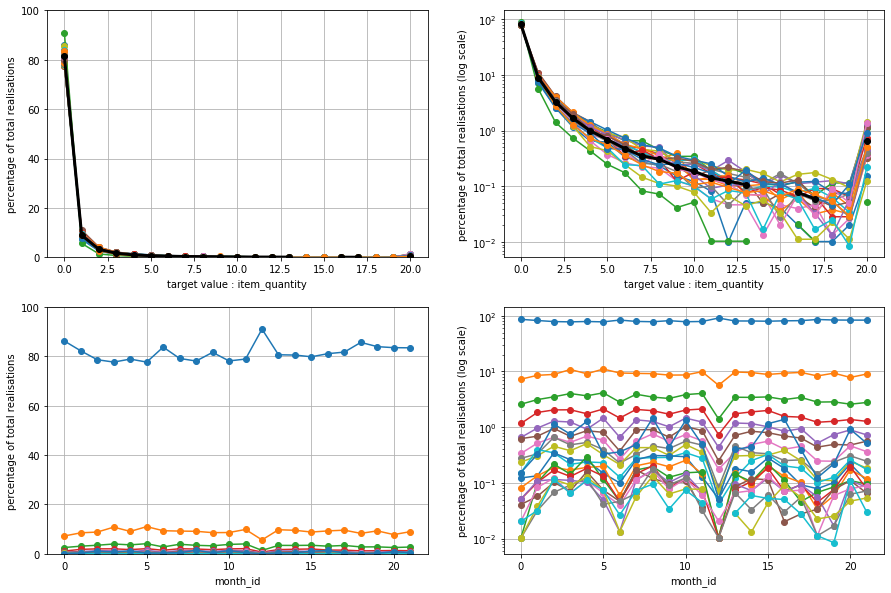

In [110]:
# Compare distributions of the target value 'item_quantity' in dataset between all months
# RESTRICT TO NEW ITEMS (seniority = 0)

idxbool=train_X['item_new']
target_label='item_quantity'

df_count=train_X.loc[idxbool,['month_id',target_label]].groupby('month_id')[target_label].value_counts()
df_count=df_count.unstack()

df_percentage=train_X.loc[idxbool,['month_id',target_label]].groupby('month_id')[target_label].value_counts(normalize=True)
df_percentage=df_percentage.unstack()*100

a=df_count.values
b=df_percentage.values

print('percentages')
print(df_percentage.iloc[:,0:5].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,5:10].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,10:15].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,15:].describe(percentiles=[]).drop('50%',axis=0))
print()
print('counts')
print(df_count.iloc[:,0:4].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,4:8].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,8:12].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,12:16].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,16:].describe(percentiles=[]).drop('50%',axis=0))

fig,axes=plt.subplots(2,2,figsize=(15,10))
axes[0,0].plot(b.T,'-o')
axes[0,0].plot(b.mean(axis=0),'-ok',linewidth=3)
axes[0,0].set_xlabel('target value : item_quantity')
axes[0,0].set_ylabel('percentage of total realisations')
axes[0,0].grid(True)
axes[0,0].set_ylim(0,100)

axes[0,1].plot(b.T,'-o')
axes[0,1].plot(b.mean(axis=0),'-ok',linewidth=3)
axes[0,1].set_xlabel('target value : item_quantity')
axes[0,1].set_ylabel('percentage of total realisations (log scale)')
axes[0,1].grid(True)
axes[0,1].set_yscale('log')

axes[1,0].plot(b,'-o')
axes[1,0].set_xlabel('month_id')
axes[1,0].set_ylabel('percentage of total realisations')
axes[1,0].grid(True)
axes[1,0].set_ylim(0,100)

axes[1,1].plot(b,'-o')
axes[1,1].set_xlabel('month_id')
axes[1,1].set_ylabel('percentage of total realisations (log scale)')
axes[1,1].grid(True)
axes[1,1].set_yscale('log')

del idxbool,target_label,axes,fig,a,b,df_count,df_percentage

# The distribution include significant contribution from quite large values
# The probability of an item being sold in quantity 13 is still 0.1%

percentages
item_quantity        0.0        1.0        2.0        3.0        4.0
count          22.000000  22.000000  22.000000  22.000000  22.000000
mean           96.090156   3.206105   0.443668   0.125764   0.053029
std             0.588643   0.395747   0.117589   0.047264   0.028732
min            94.056095   2.649887   0.273345   0.045840   0.015280
max            96.806521   4.278190   0.895022   0.302717   0.168348
item_quantity        5.0        6.0        7.0        8.0        9.0
count          22.000000  22.000000  22.000000  22.000000  21.000000
mean            0.028065   0.015991   0.010100   0.006983   0.004455
std             0.017697   0.012734   0.007087   0.005782   0.003959
min             0.007640   0.003396   0.001266   0.001698   0.001098
max             0.095757   0.064868   0.033206   0.029345   0.017761
item_quantity       10.0       11.0       12.0       13.0       14.0
count          21.000000  19.000000  14.000000  12.000000  16.000000
mean            0.0034

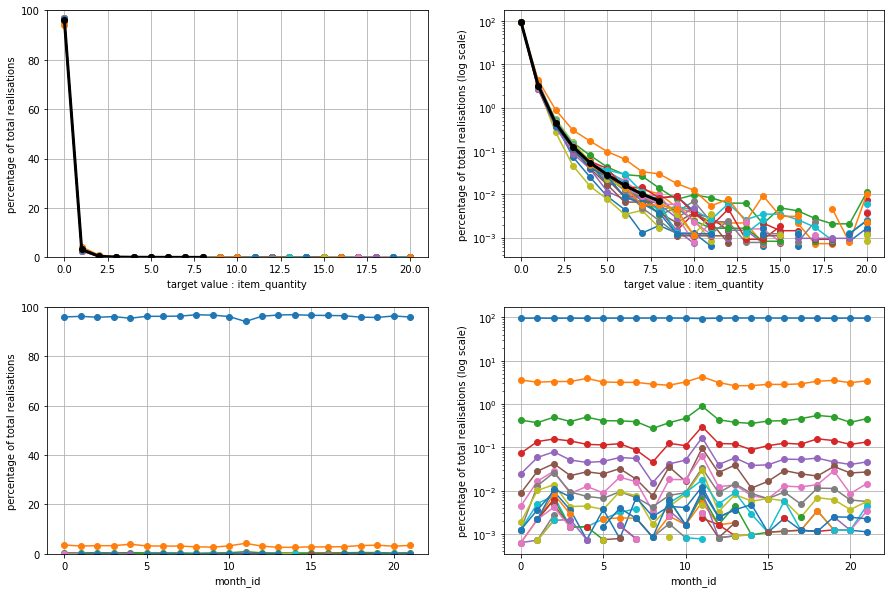

In [111]:
# Compare distributions of the target value 'item_quantity' in dataset between all months
# RESTRICT TO ITEM_NEVER_SOLD_IN_SHOP_BEFORE_BUT_NOT_NEW (seniority = 1)

idxbool=train_X['item_never_sold_in_shop_before_but_not_new']
target_label='item_quantity'

df_count=train_X.loc[idxbool,['month_id',target_label]].groupby('month_id')[target_label].value_counts()
df_count=df_count.unstack()

df_percentage=train_X.loc[idxbool,['month_id',target_label]].groupby('month_id')[target_label].value_counts(normalize=True)
df_percentage=df_percentage.unstack()*100

a=df_count.values
b=df_percentage.values

print('percentages')
print(df_percentage.iloc[:,0:5].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,5:10].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,10:15].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,15:].describe(percentiles=[]).drop('50%',axis=0))
print()
print('counts')
print(df_count.iloc[:,0:4].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,4:8].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,8:12].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,12:16].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,16:].describe(percentiles=[]).drop('50%',axis=0))

fig,axes=plt.subplots(2,2,figsize=(15,10))
axes[0,0].plot(b.T,'-o')
axes[0,0].plot(b.mean(axis=0),'-ok',linewidth=3)
axes[0,0].set_xlabel('target value : item_quantity')
axes[0,0].set_ylabel('percentage of total realisations')
axes[0,0].grid(True)
axes[0,0].set_ylim(0,100)

axes[0,1].plot(b.T,'-o')
axes[0,1].plot(b.mean(axis=0),'-ok',linewidth=3)
axes[0,1].set_xlabel('target value : item_quantity')
axes[0,1].set_ylabel('percentage of total realisations (log scale)')
axes[0,1].grid(True)
axes[0,1].set_yscale('log')

axes[1,0].plot(b,'-o')
axes[1,0].set_xlabel('month_id')
axes[1,0].set_ylabel('percentage of total realisations')
axes[1,0].grid(True)
axes[1,0].set_ylim(0,100)

axes[1,1].plot(b,'-o')
axes[1,1].set_xlabel('month_id')
axes[1,1].set_ylabel('percentage of total realisations (log scale)')
axes[1,1].grid(True)
axes[1,1].set_yscale('log')

del idxbool,target_label,axes,fig,a,b,df_count,df_percentage

# 95% of items are NOT sold, and the amount of realisations is rapidly decreasing when the number of items sold increases
# The probability of an item being sold in amounts superior to 3 is less than 0.1% !

percentages
item_quantity        0.0        1.0        2.0        3.0        4.0
count          22.000000  22.000000  22.000000  22.000000  22.000000
mean           77.872262  14.412827   3.877260   1.503645   0.760251
std             1.963036   0.615252   0.438563   0.283385   0.177632
min            71.972150  13.147035   3.292345   1.153543   0.529987
max            80.887641  15.709786   5.108285   2.435946   1.341402
item_quantity        5.0        6.0        7.0        8.0        9.0
count          22.000000  22.000000  22.000000  22.000000  22.000000
mean            0.441212   0.278970   0.185046   0.132399   0.095209
std             0.120511   0.092171   0.063208   0.056785   0.039205
min             0.285593   0.164792   0.113818   0.071922   0.048181
max             0.835375   0.570665   0.384753   0.320730   0.222849
item_quantity       10.0       11.0       12.0       13.0       14.0
count          22.000000  22.000000  22.000000  22.000000  22.000000
mean            0.0745

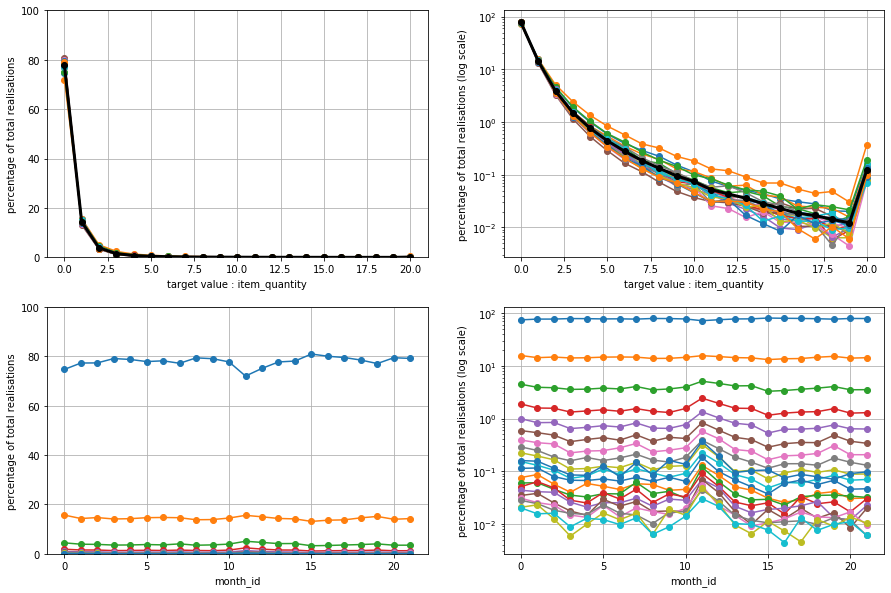

In [112]:
# Compare distributions of the target value 'item_quantity' in dataset between all months
# RESTRICT TO ITEM_SOLD_IN_SHOP_BEFORE (seniority = 2)

idxbool=~train_X['item_never_sold_in_shop_before']
target_label='item_quantity'

df_count=train_X.loc[idxbool,['month_id',target_label]].groupby('month_id')[target_label].value_counts()
df_count=df_count.unstack()

df_percentage=train_X.loc[idxbool,['month_id',target_label]].groupby('month_id')[target_label].value_counts(normalize=True)
df_percentage=df_percentage.unstack()*100

a=df_count.values
b=df_percentage.values

print('percentages')
print(df_percentage.iloc[:,0:5].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,5:10].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,10:15].describe(percentiles=[]).drop('50%',axis=0))
print(df_percentage.iloc[:,15:].describe(percentiles=[]).drop('50%',axis=0))
print()
print('counts')
print(df_count.iloc[:,0:4].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,4:8].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,8:12].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,12:16].describe(percentiles=[]).drop('50%',axis=0))
print(df_count.iloc[:,16:].describe(percentiles=[]).drop('50%',axis=0))

fig,axes=plt.subplots(2,2,figsize=(15,10))
axes[0,0].plot(b.T,'-o')
axes[0,0].plot(b.mean(axis=0),'-ok',linewidth=3)
axes[0,0].set_xlabel('target value : item_quantity')
axes[0,0].set_ylabel('percentage of total realisations')
axes[0,0].grid(True)
axes[0,0].set_ylim(0,100)

axes[0,1].plot(b.T,'-o')
axes[0,1].plot(b.mean(axis=0),'-ok',linewidth=3)
axes[0,1].set_xlabel('target value : item_quantity')
axes[0,1].set_ylabel('percentage of total realisations (log scale)')
axes[0,1].grid(True)
axes[0,1].set_yscale('log')

axes[1,0].plot(b,'-o')
axes[1,0].set_xlabel('month_id')
axes[1,0].set_ylabel('percentage of total realisations')
axes[1,0].grid(True)
axes[1,0].set_ylim(0,100)

axes[1,1].plot(b,'-o')
axes[1,1].set_xlabel('month_id')
axes[1,1].set_ylabel('percentage of total realisations (log scale)')
axes[1,1].grid(True)
axes[1,1].set_yscale('log')

del idxbool,target_label,axes,fig,a,b,df_count,df_percentage

# The distribution of sales is fairly even from month to month
# The probability of an item being sold in a given quantity decreases quite smoothly and rapidly with the amount of quantities
# The probability that an item is sold in quantity 9 is 0.1%

## ANALYSIS OF TEMPORAL TRENDS

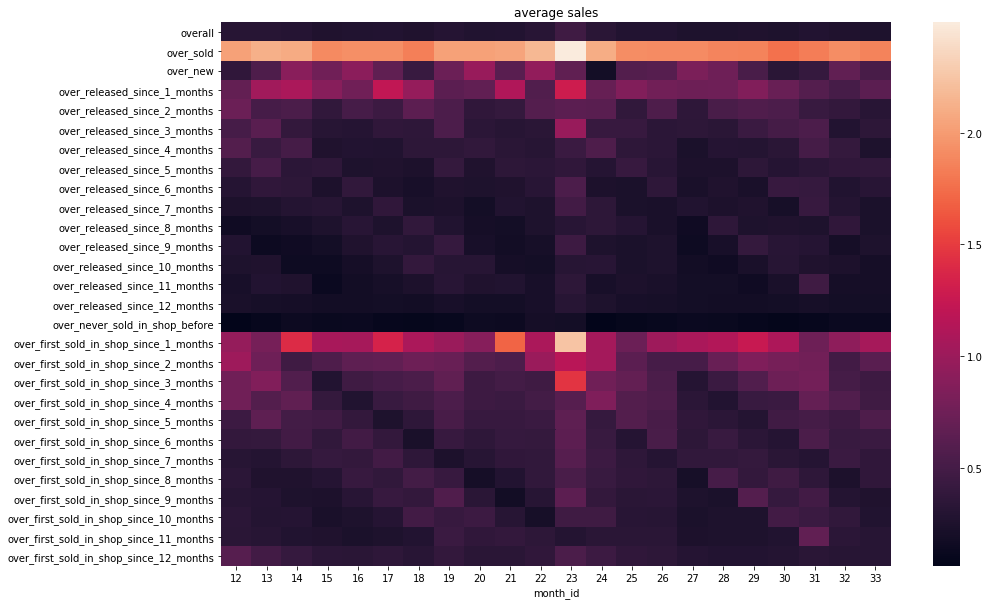

In [113]:
# Analyse the mean of target value over all months
tmp_avg=train_X[['month_id','item_quantity']].groupby('month_id').mean()
tmp_avg.rename({'item_quantity':'overall'},axis=1,inplace=True)

idxbool=(train_X['item_quantity']>0)
tmp_avg['over_sold']=train_X.loc[idxbool,['month_id','item_quantity']].groupby('month_id').mean()

idxbool=(train_X['item_new'])
tmp_avg['over_new']=train_X.loc[idxbool,['month_id','item_quantity']].groupby('month_id').mean()

for i in range(1,13):
    idxbool=(train_X['item_months_since_release']==i)
    tmp_avg['over_released_since_'+str(i)+'_months']=train_X.loc[idxbool,['month_id','item_quantity']].groupby('month_id').mean()

idxbool=(train_X['item_never_sold_in_shop_before'])
tmp_avg['over_never_sold_in_shop_before']=train_X.loc[idxbool,['month_id','item_quantity']].groupby('month_id').mean()
 
for i in range(1,13):
    idxbool=(train_X['item_months_since_first_sale_in_shop']==i)
    tmp_avg['over_first_sold_in_shop_since_'+str(i)+'_months']=train_X.loc[idxbool,['month_id','item_quantity']].groupby('month_id').mean()
    
    
    
# display    
plt.figure(figsize=(15,10))
sns.heatmap(tmp_avg.T)
plt.title('average sales')

del tmp_avg

There seem to be a peak of average sales on December months.

We also notice that the sale quantities of items released in October, November, December appears to remain consistently higher than average the next months. Conversely, items released in February are sold in smaller quantities all year round.

--> There is an influence of the month where the item is first released!

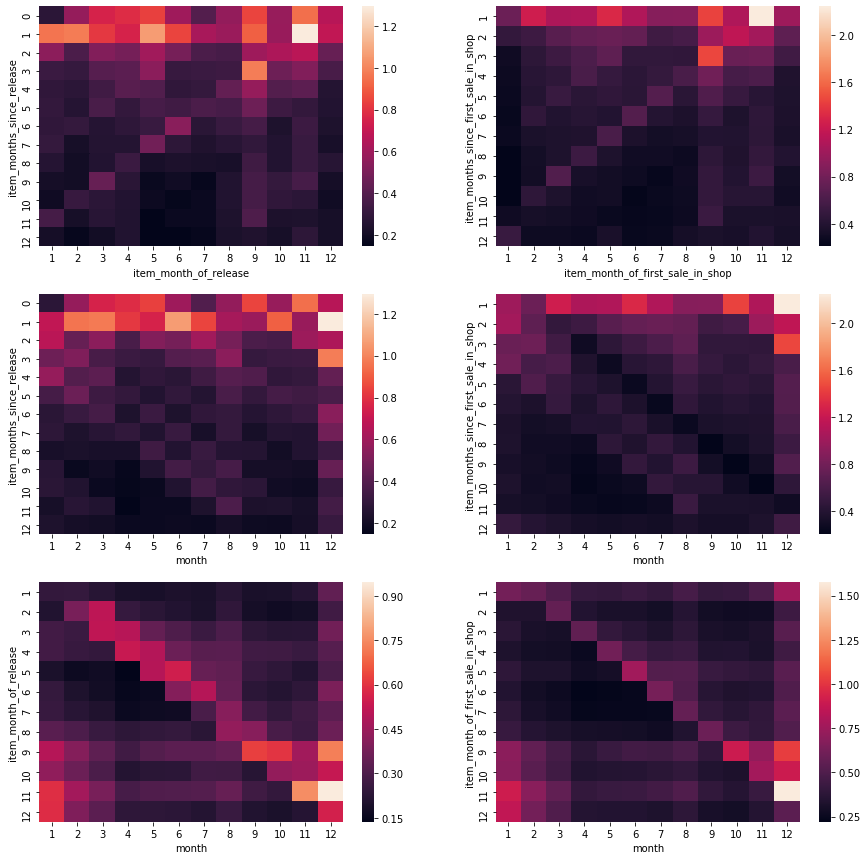

In [114]:
fig,axes=plt.subplots(3,2,figsize=(15,15))
sns.heatmap(train_X[['item_month_of_release','item_months_since_release','item_quantity']].groupby(['item_month_of_release','item_months_since_release']).mean()['item_quantity'].unstack(level=0),ax=axes[0,0])
sns.heatmap(train_X.loc[~train_X['item_never_sold_in_shop_before'],['item_month_of_first_sale_in_shop','item_months_since_first_sale_in_shop','item_quantity']].groupby(['item_month_of_first_sale_in_shop','item_months_since_first_sale_in_shop']).mean()['item_quantity'].unstack(level=0),ax=axes[0,1])
sns.heatmap(train_X[['month','item_months_since_release','item_quantity']].groupby(['month','item_months_since_release']).mean()['item_quantity'].unstack(level=0),ax=axes[1,0])
sns.heatmap(train_X.loc[~train_X['item_never_sold_in_shop_before'],['month','item_months_since_first_sale_in_shop','item_quantity']].groupby(['month','item_months_since_first_sale_in_shop']).mean()['item_quantity'].unstack(level=0),ax=axes[1,1])
sns.heatmap(train_X[['month','item_month_of_release','item_quantity']].groupby(['month','item_month_of_release']).mean()['item_quantity'].unstack(level=0),ax=axes[2,0])
sns.heatmap(train_X.loc[~train_X['item_never_sold_in_shop_before'],['month','item_month_of_first_sale_in_shop','item_quantity']].groupby(['month','item_month_of_first_sale_in_shop']).mean()['item_quantity'].unstack(level=0),ax=axes[2,1])

We also notice a storng influence of the time spent wince the item has been released: on average, newer items are sold in larger quantities than older ones.

--> There is an influence of the number of months since the item was first released (or first sold in shop)

## DISTRIBUTION OF SALES AMONG SHOPS THROUGH TIME

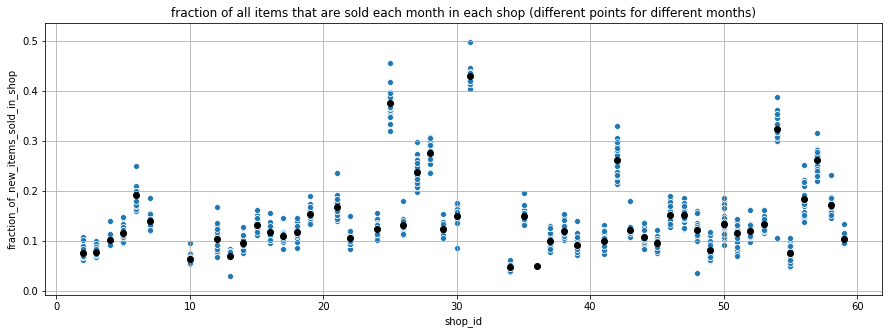

In [115]:
tmp=train_X.loc[:,['month_id','shop_id','item_quantity']]
tmp['sold']=(tmp['item_quantity']>0)
tmp['count']=(tmp['item_quantity']>=0)
tmp.drop('item_quantity',axis=1,inplace=True)
tmp_1=tmp.groupby(['month_id','shop_id'],as_index=False).sum()
tmp_1['fraction_of_new_items_sold_in_shop']=tmp_1['sold']/tmp_1['count']


tmp=tmp.groupby(['month_id','shop_id']).sum()
tmp['fraction_of_all_items_sold_in_shop']=tmp['sold']/tmp['count']
tmp=tmp['fraction_of_all_items_sold_in_shop'].unstack()



fig=plt.figure(figsize=(15,5))
sns.scatterplot(data=tmp_1,x='shop_id',y='fraction_of_new_items_sold_in_shop')
plt.plot(tmp.columns,tmp.mean(),'ok')
plt.grid(True)
plt.title('fraction of all items that are sold each month in each shop (different points for different months)')
plt.show()

del tmp, tmp_1, fig

# SOME SHOPS SELL A LARGER PORTION OF THE GLOBAL CATALOGUE THAN OTHERS

In [116]:
# clear memory
del train_X

gc.collect()

32924

In [117]:
reset_variable_space